# sensitivity of (e,e'pp)/(e,e'p) ratio to selection cuts

In [1]:
from notebook_tools import *
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
from pylab import *
majorLocator   = MultipleLocator(0.01)
%matplotlib inline

In [2]:
PmissBins = [[0.3,0.45]  , [0.45,0.55] , [0.55,0.65] , [0.65,0.75] , [0.75,1.0]]
pmiss_analysis_bins , pmiss_analysis_bins_center , pmiss_multiples_bins , pmiss_bin_center = [] , [] , [] , []
for i in range(len(PmissBins)):
    pmin , pmax = PmissBins[i][0] , PmissBins[i][1]
    for j in range(4):
        pmiss_multiples_bins.append( [ pmin + float(j*(pmax-pmin))/4 , pmin + float((j+1)*(pmax-pmin))/4 ])
    for j in range(2):
        pmiss_analysis_bins.append( [ pmin + float(j*(pmax-pmin))/2 , pmin + float((j+1)*(pmax-pmin))/2 ])

for i in range( len(pmiss_multiples_bins) ):
    pmin , pmax = pmiss_multiples_bins[i][0] , pmiss_multiples_bins[i][1]
    pmiss_bin_center.append(0.5*(pmin+pmax))
print 'pmiss_bin_center:',pmiss_bin_center
for i in range( len(pmiss_analysis_bins) ):
    pmin , pmax = pmiss_analysis_bins[i][0] , pmiss_analysis_bins[i][1]
    pmiss_analysis_bins_center.append(0.5*(pmin+pmax))
print 'pmiss_analysis_bins_center:',pmiss_analysis_bins_center

pmiss_bin_center: [0.31875, 0.35625, 0.39375, 0.43125, 0.4625, 0.48750000000000004, 0.5125, 0.5375000000000001, 0.5625, 0.5875000000000001, 0.6125, 0.6375, 0.6625000000000001, 0.6875, 0.7124999999999999, 0.7375, 0.78125, 0.84375, 0.90625, 0.96875]
pmiss_analysis_bins_center: [0.3375, 0.4125, 0.475, 0.525, 0.5750000000000001, 0.625, 0.675, 0.725, 0.8125, 0.9375]


# (e,e'pp)/(e,e'p) ratio from DATA with no acceptance correction

In [3]:
def eepp_eep_in_pmiss_bins(eep=TPlots() , eepp=TPlots(),                 
                               cut='',
                               cut_name='nominal_cuts',                      
                               target = 'C12',
                               pmiss_bins=None,                    
                              ):
    
    pmiss_bin_center , eep_in_pmiss_bins , eepp_in_pmiss_bins = [] , [] , []
    for i in range( len(pmiss_bins) ):
        pmin , pmax = pmiss_bins[i][0] , pmiss_bins[i][1]
        pmiss_bin_center.append(0.5*(pmin+pmax))
        if 'nominal' in cut_name:
            selection_cut = ROOT.TCut("(%f<Pmiss3Mag && Pmiss3Mag<%f)"%(pmin , pmax))
        else:
            selection_cut = ROOT.TCut("(%f<Pmiss3Mag && Pmiss3Mag<%f) && (%s)"%(pmin , pmax , cut))
        
        eep_in_pmiss_bins.append( eep.GetEntries(selection_cut) )
        eepp_in_pmiss_bins.append( eepp.GetEntries(selection_cut) )
    
    return pmiss_bin_center , np.array(eep_in_pmiss_bins) , np.array(eepp_in_pmiss_bins)


In [4]:
def eepp_eep_ratio(eep=TPlots() , eepp=TPlots(), 
                   cut='',
                   cut_name='nominal_cuts',                      
                   target = 'C12', target_name = '$^{12}$C',                   
                   pmiss_bins=None,                    
                   do_plot=True,
                   do_save_plots=True):
    
    bins, Neep, Neepp = eepp_eep_in_pmiss_bins(eep=eep , eepp=eepp,                 
                                               cut=cut,
                                               cut_name=cut_name,                      
                                               target=target,
                                               pmiss_bins=pmiss_bins)
    ratio , ratio_err =  [] , [] 
    for i in range(len(bins)):
        ratio.append(100*float(Neepp[i])/Neep[i])
        ratio_err.append(ratio[-1] * np.sqrt(1./Neepp[i] + 1./Neep[i]))
     
    if do_plot:
        fig,ax = plt.subplots(figsize=(15,10))
        plt.errorbar(pmiss_bin_center,ratio,xerr=np.zeros(len(pmiss_bin_center)),yerr=ratio_err,fmt='ro', color='black',markersize=20)
        set_axes(ax , x_label=r'$|\vec{p}_{miss}|$ [GeV/c]',y_label= r"%s ${\frac{(e,e'pp)}{(e,e'p)}}$"%target_name + ' [%]')
        ax.grid()
        ax.set_ylim(0,1.02*np.max(ratio)+np.max(ratio_err))
        ax.set_xlim(0.25,1.01)
        
        if do_save_plots:
            fig.savefig('/Users/erezcohen/Desktop/DataMining/AccCorr_ppSRCAnalysisNote/all_figures/eeppeep_sensitivity_studies/eeppeep_measured_%s_%s.pdf'%(cut_name,target))

    return bins , ratio , ratio_err

In [5]:
def eta( a , b ):
    ab_avg , ab_diff = 0.5*(a+b) , [float(a[i]-b[i]) for i in range(len(a))]
    eta = [float(ab_diff[i])/ab_avg[i] if ab_avg[i]>0 else 0.01 for i in range(len(a))]
    eta_err = [np.sqrt(np.abs(ab_diff[i]))/ab_avg[i] if ab_avg[i]>0 else 0.01 for i in range(len(a))]
#     print 'eta:',eta
#     print 'eta_err:',eta_err
    return np.array(eta) , np.array(eta_err)

In [10]:
def modeified_eep_eepp(modified_cut_name='Xb' ,nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$'],                                         
                       target='C12',target_name='$^{12}$C',                  
                       cutXb = '1.2<Xb' ,cut_theta_pq = 'theta_pq<25', cut_p_over_q ='fabs(p_over_q-0.79) < 0.17',cut_m_miss = 'Mmiss < 1.100',
                       do_make_plots=False,do_save_plots=False,
                       ytext=None,pmiss_bins=None,do_Or_new_method_Jan2017=True     
                      ):
    
    # nominal number of (e,e'p) and (e,e'pp) events
    eep_nominal = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_eep_in_ppSRCCut_DATA_%s.root'%target , 'anaTree')
    eepp_nominal = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_ppSRCCut_DATA_%s.root'%target , 'anaTree')

    bins, Neep_nominal, Neepp_nominal = eepp_eep_in_pmiss_bins(eep=eep_nominal , eepp=eepp_nominal,                 
                                               cut='', cut_name='nominal_cuts',                      
                                               target=target, pmiss_bins=pmiss_bins)
    x = bins


    # excess of events
    eep_relaxed = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_eep_in_relaxed_ppSRCCut_DATA_%s.root'%target , 'anaTree')
    eepp_relaxed = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_relaxed_ppSRCCut_DATA_%s.root'%target , 'anaTree')
    cut = '(%s) && (%s) && (%s) && (%s)'%(cutXb,cut_theta_pq,cut_p_over_q,cut_m_miss)
    bins, Neep_relaxed, Neepp_relaxed = eepp_eep_in_pmiss_bins(eep=eep_relaxed , eepp=eepp_relaxed,                 
                                               cut=cut, cut_name=modified_cut_name,                      
                                               target=target,pmiss_bins=pmiss_bins)

    eta_eep , eta_eep_err = eta( Neep_relaxed , Neep_nominal )
    eta_eepp , eta_eepp_err = eta( Neepp_relaxed , Neepp_nominal )

    r_nom = Neepp_nominal.astype(float)/Neep_nominal
    r_mod = Neepp_relaxed.astype(float)/Neep_relaxed
    r_nom_err = r_nom*np.sqrt(1./Neep_nominal+1./Neepp_nominal)
    r_mod_err = r_mod*np.sqrt(1./Neep_relaxed+1./Neepp_relaxed)
    r_avg , r_diff = 100*0.5*(r_mod+r_nom) , 100*(r_mod-r_nom)


    # Or newest method
    A, dA = Neepp_nominal.astype(float) , (Neepp_relaxed-Neepp_nominal).astype(float)
    DA,DdA= np.sqrt(A) , np.sqrt(np.abs(dA))
    B, dB = Neep_nominal.astype(float) , (Neep_relaxed-Neep_nominal).astype(float)
    DB,DdB= np.sqrt(B) , np.sqrt(np.abs(dB))
    
    eta_AB = (A*dB-B*dA)/(B*(B+dB))
    eta_AB_err = (1./(B*(B+dB))) * np.sqrt(np.square( DA * dB ) 
                                          + np.square( DB * ( B*dA*(2*B+dB) - dA*B*(B+dB) )/( B*(B+dB) ) ) 
                                          + np.square( DdA * B )
                                          + np.square( DdB * ( A*B*(B+dB) - B*B*dA )/( B*(B+dB) ) ) ) 

    
    eta_AB_percent = 100*eta_AB/( 0.5*(r_mod+r_nom) )
    eta_AB_percent_err = 100*eta_AB_err/( 0.5*(r_mod+r_nom) )

    if do_prints:
        print 'eta_AB:',eta_AB
        print 'eta_AB_err:',eta_AB_err
        print 'eta_AB_percent:',eta_AB_percent
        print 'eta_AB_percent_err:',eta_AB_percent_err

    
    
    if do_make_plots:
        fig = plt.figure(figsize=(20,12))
        
        ax = fig.add_subplot(211)
        ax.errorbar(x=x , y=100*r_nom , yerr=100*r_nom_err , fmt='o',markersize=10 , color='blue' , label=nominal_and_modified_cut_names[0])
        ax.errorbar(x=x-0.01*np.ones(len(x)) , y=100*r_mod , yerr=100*r_mod_err , fmt='s',markersize=10 , color='red' , label=nominal_and_modified_cut_names[1] )
        ax.xaxis.set_major_formatter( NullFormatter() )
        ax.grid()
        ax.legend(fontsize=25,loc='best')
        set_axes(ax,x_label='',y_label=r"%s ${\frac{(e,e'pp)}{(e,e'p)}}$"%target_name + ' [%]', fontsize=30)

#         ax = fig.add_subplot(312)
#         ax.errorbar(x , 100*eta_eep , yerr=100*eta_eep_err , fmt='o',markersize=10 , label="$\eta_{(e,e'p)}$" )
#         ax.xaxis.set_major_formatter( NullFormatter() )
#         ax.grid()
#         ax.errorbar(x , 100*eta_eepp , yerr=100*eta_eepp_err , fmt='o',markersize=10 , label="$\eta_{(e,e'pp)}$" )
#         ax.xaxis.set_major_formatter( NullFormatter() )
#         plt.legend(fontsize=30,loc='best')
#         set_axes(ax,x_label='',y_label=r"$\eta$ [%]", fontsize=30)
#         start, end = ax.get_ylim()
#         ax.set_ylim(np.min([-10,100*(np.min(eta_eepp-2*eta_eepp_err))]),np.max([10,100*(np.max(eta_eepp+2*eta_eepp_err))]))
        
        eta_r = [100*r_diff[i]/r_avg[i] if r_avg[i]>1 else 1 for i in range(len(x))]
        eta_r_err = [100*np.sqrt(np.abs(r_diff[i]))/r_avg[i] if r_avg[i]>1 else 1 for i in range(len(x))]
        
        ax = fig.add_subplot(212)
        
        if do_Or_new_method_Jan2017 is not True: # Or method from the previos report
            y , yerr = eta_r , eta_r_err
        if do_Or_new_method_Jan2017 is True: # Or newest method from January-24
            y , yerr = eta_AB_percent , eta_AB_percent_err
        ax.errorbar(x=x , y=y , yerr=yerr , fmt='o',markersize=10 , color='black' )
        ax.grid()
        set_axes(ax,x_label=r'$|\vec{p}_{miss}|$ [GeV/c]',y_label="$\eta_{(e,e'pp)/(e,e'p)}$ [%]", fontsize=30)

        simga2_inverse = [1./np.square(yerr[i]) if yerr[i]>0.01 else 0.01 for i in range(len(x))]
        mean = np.average(y , weights=simga2_inverse)
        sigma = np.sqrt(np.average(np.square(y-mean),weights=simga2_inverse))
        
        y , yerr = mean*np.ones(len(x)) , sigma*np.ones(len(x))  
        plt.plot( x , y , 'r-')
        plt.fill_between( x , y-yerr , y+yerr , color='red' , alpha=0.1) 
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end-0.01*(end-start), (end-start)/5))
        if ytext is None: 
            ytext = start+0.1*(end-start) if mean<0 else end-0.3*(end-start)
        plt.text(0.5 , ytext , '$%.3f \\pm %.3f $'%(mean,sigma)+' %' , color='red' , fontsize=35) 


        subplots_adjust(hspace=0)        
        
        if do_save_plots:
            plt.tight_layout()
            fig.savefig('/Users/erezcohen/Desktop/DataMining/AccCorr_ppSRCAnalysisNote/all_figures/eepp_eep_modifiedcut_%s_%s.pdf'%(modified_cut_name,target))
        
        eep_nominal.Close()
        eepp_nominal.Close()
        eep_relaxed.Close()
        eepp_relaxed.Close()
 
        return mean,sigma



C12 
-------------
xB>1.2 cut sensitivity: 7.805
theta_pq<25 cut sensitivity: 0.21
p/q<25 cut sensitivity: 2.574
Mmiss < 1.1 cut sensitivity: 6.337
tot. syst. uncertainty due to the event selection cut: 10.380

Al27 
-------------
xB>1.2 cut sensitivity: 14.723
theta_pq<25 cut sensitivity: 2.19
p/q<25 cut sensitivity: 2.209
Mmiss < 1.1 cut sensitivity: 4.409
tot. syst. uncertainty due to the event selection cut: 15.681

Fe56 
-------------
xB>1.2 cut sensitivity: 6.475
theta_pq<25 cut sensitivity: 1.53
p/q<25 cut sensitivity: 2.851
Mmiss < 1.1 cut sensitivity: 7.482
tot. syst. uncertainty due to the event selection cut: 10.410

Pb208 
-------------
xB>1.2 cut sensitivity: 17.363
theta_pq<25 cut sensitivity: 2.90
p/q<25 cut sensitivity: 2.682
Mmiss < 1.1 cut sensitivity: 12.685
tot. syst. uncertainty due to the event selection cut: 21.863


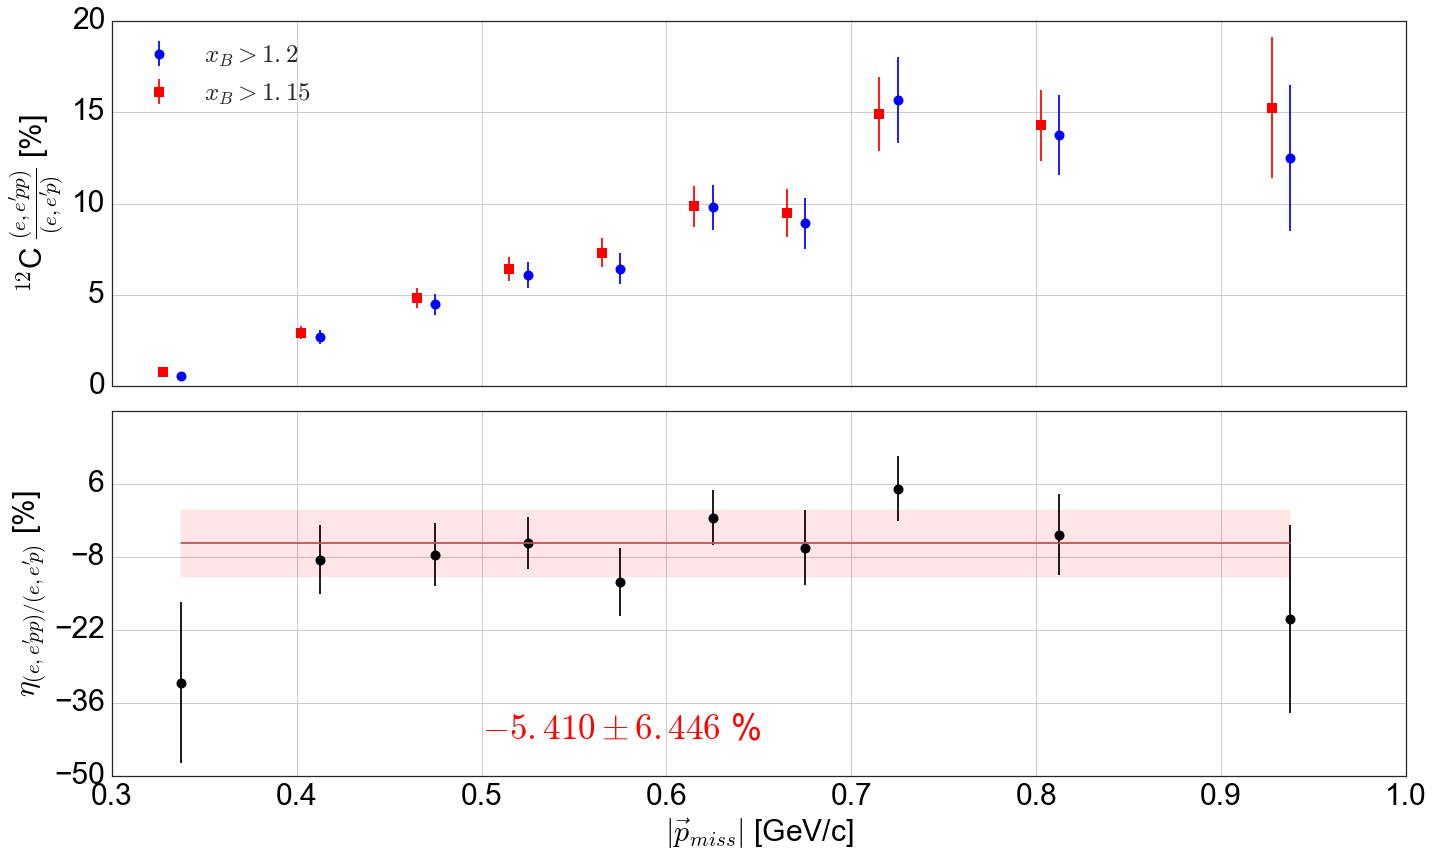

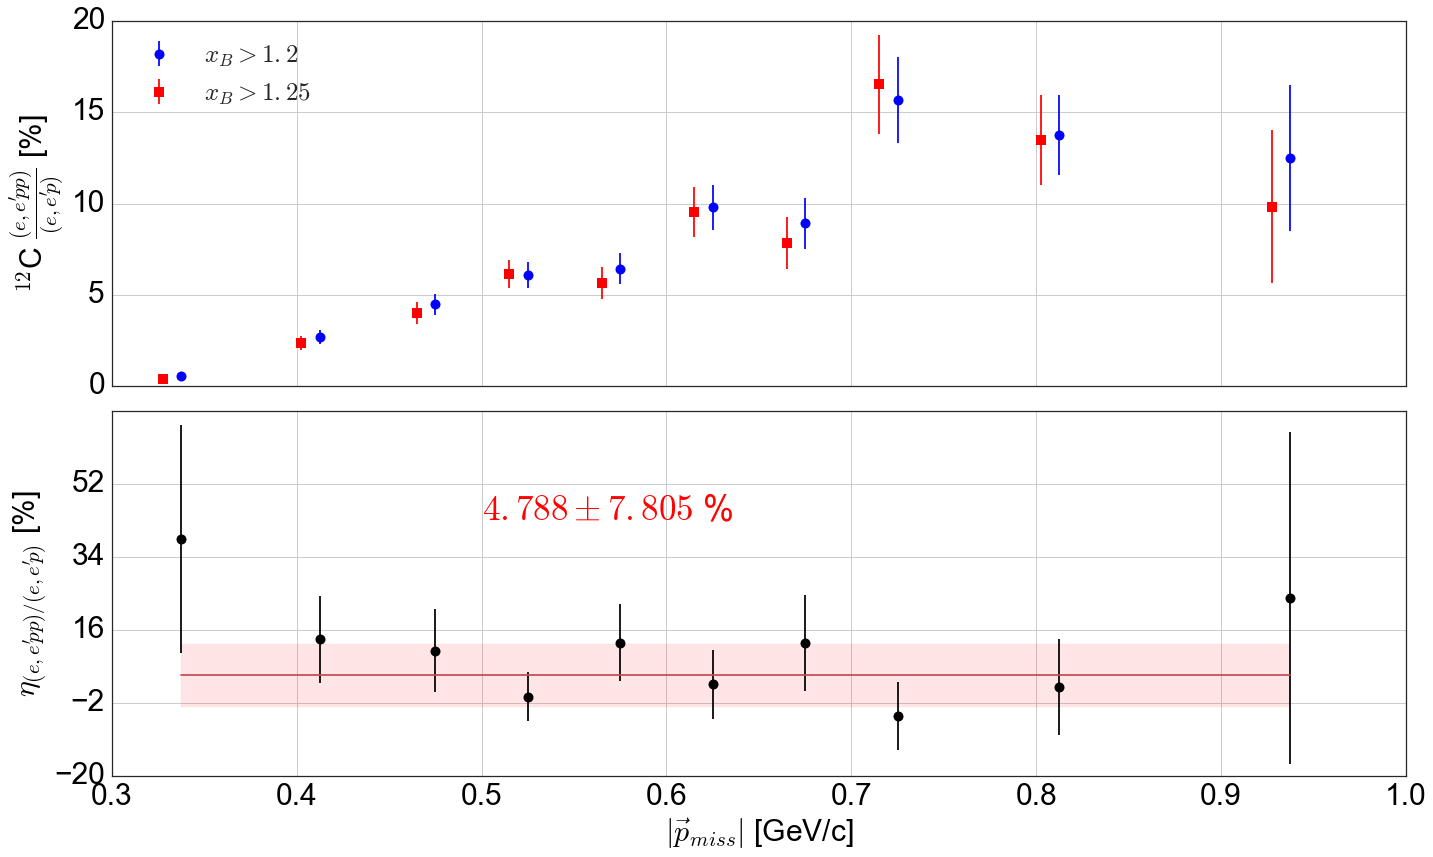

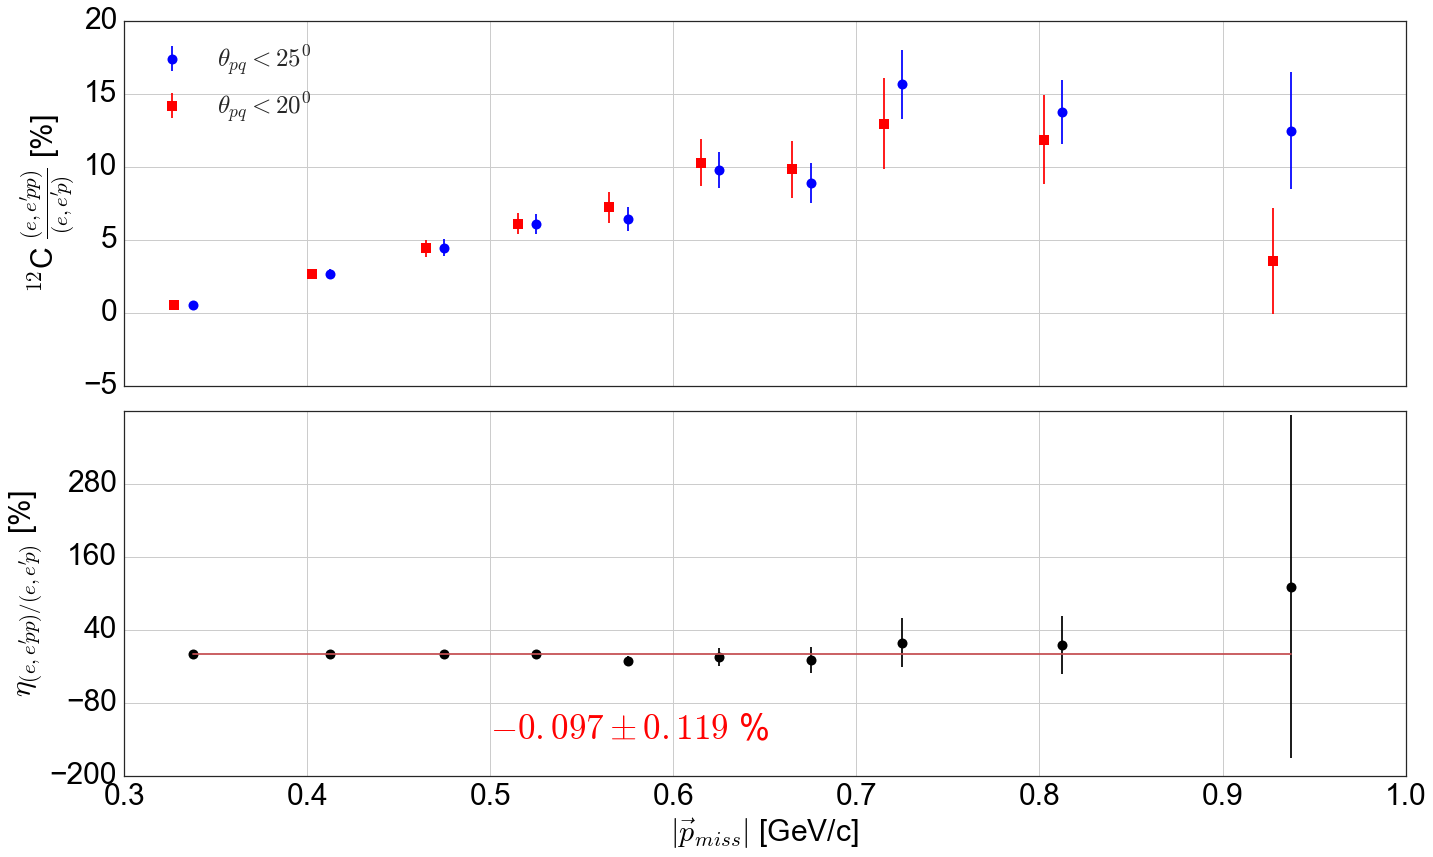

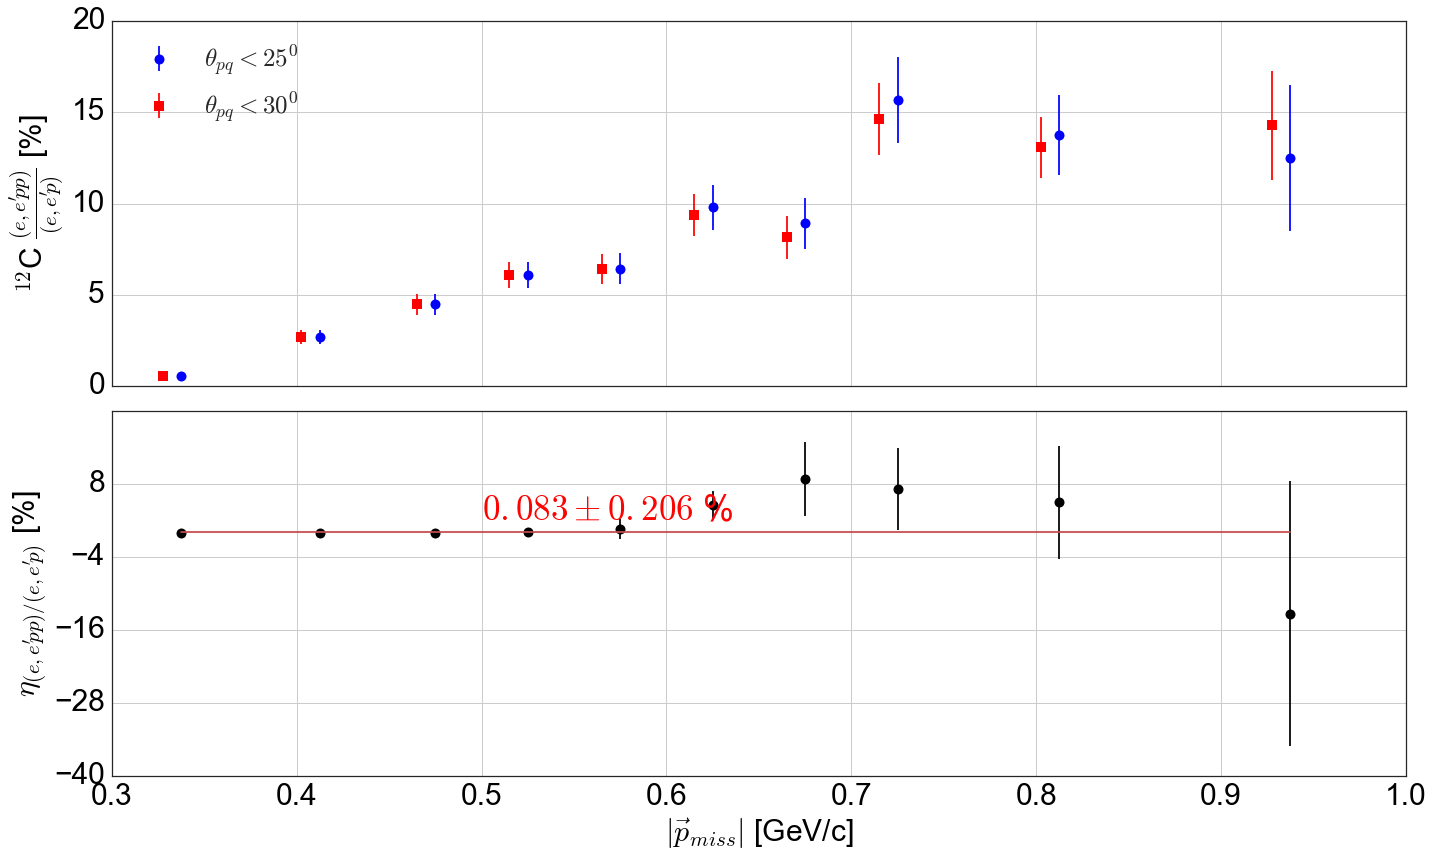

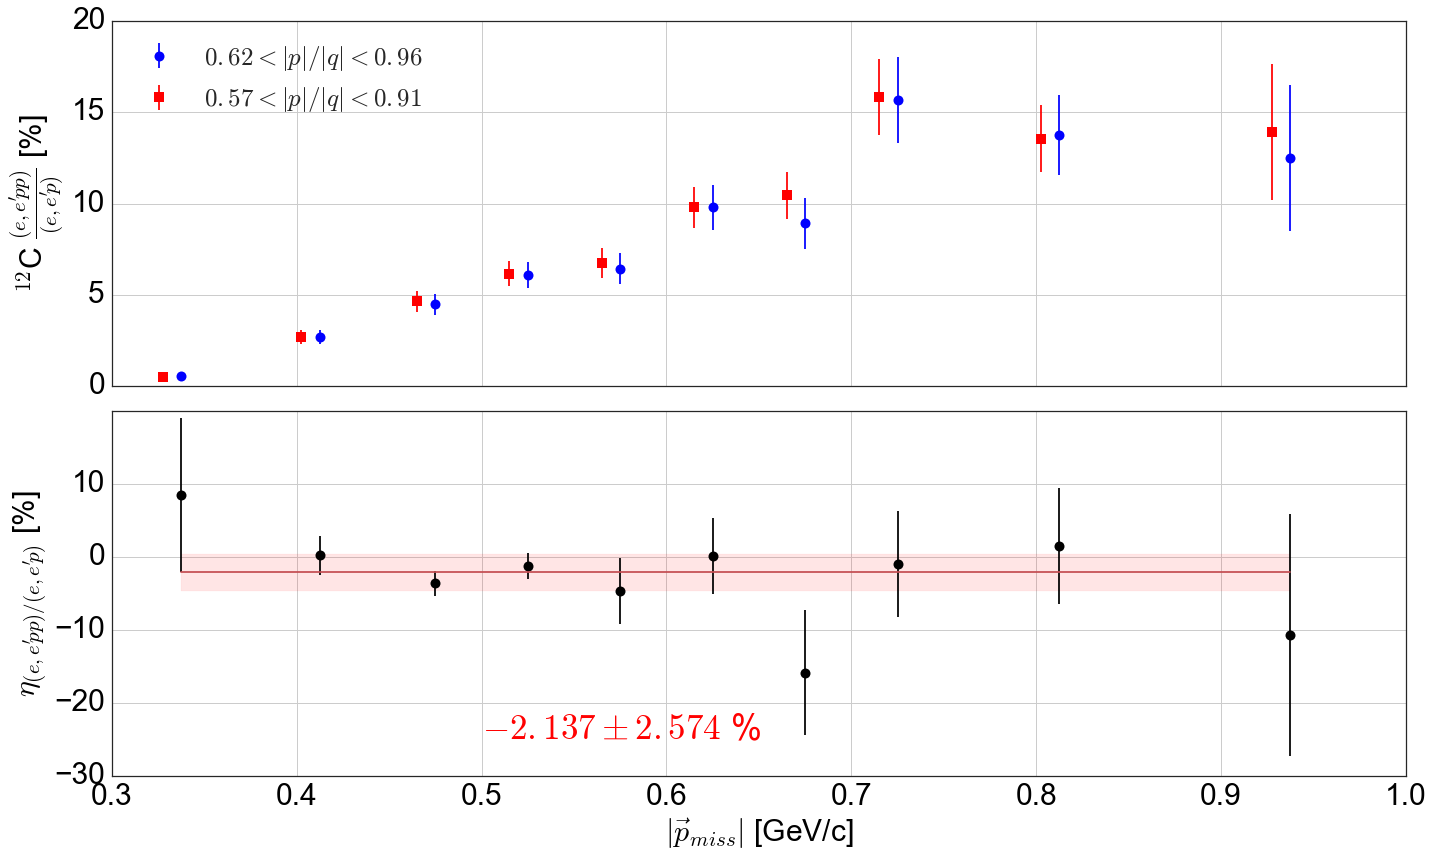

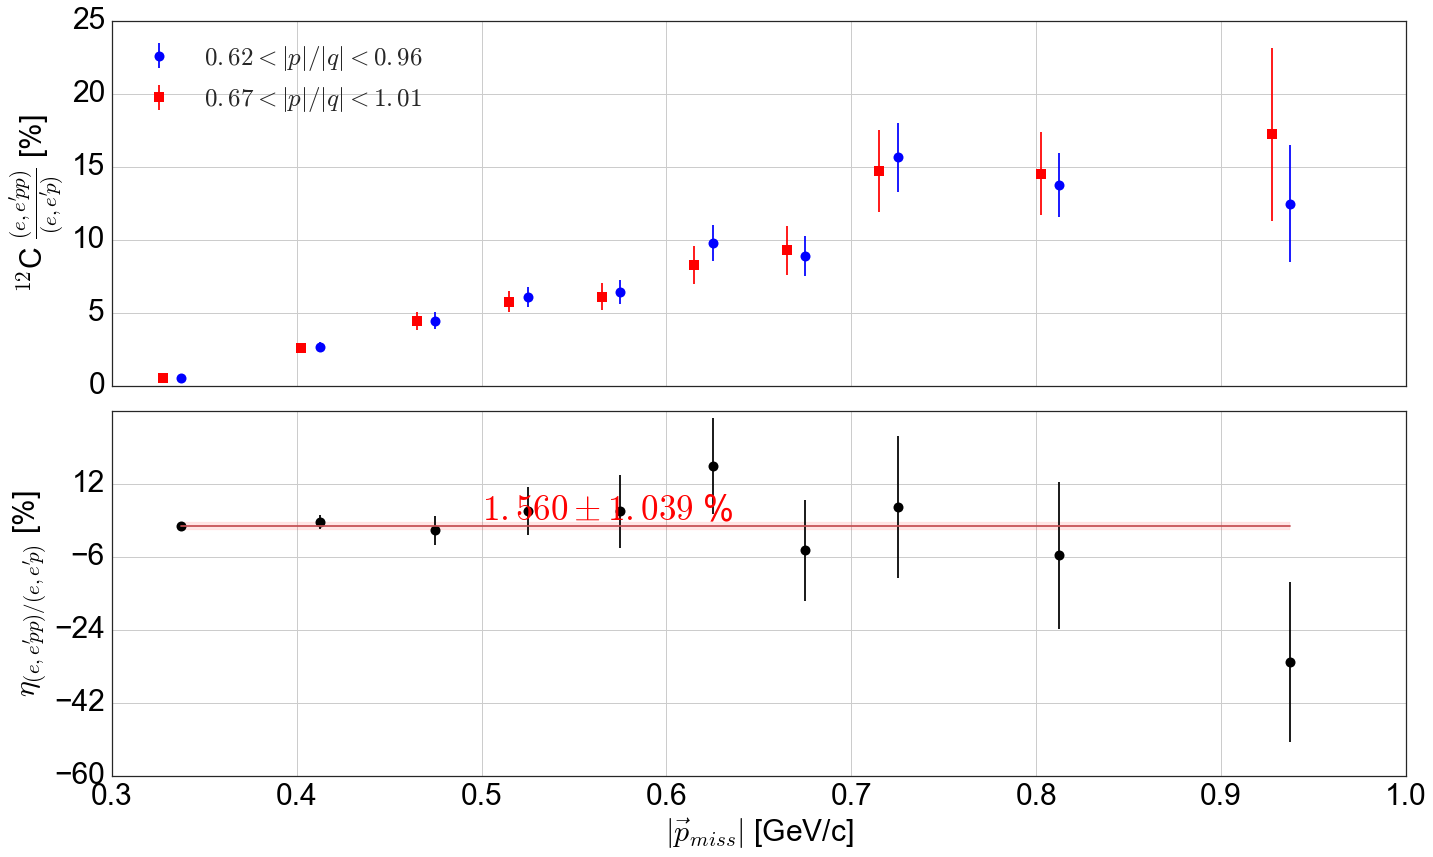

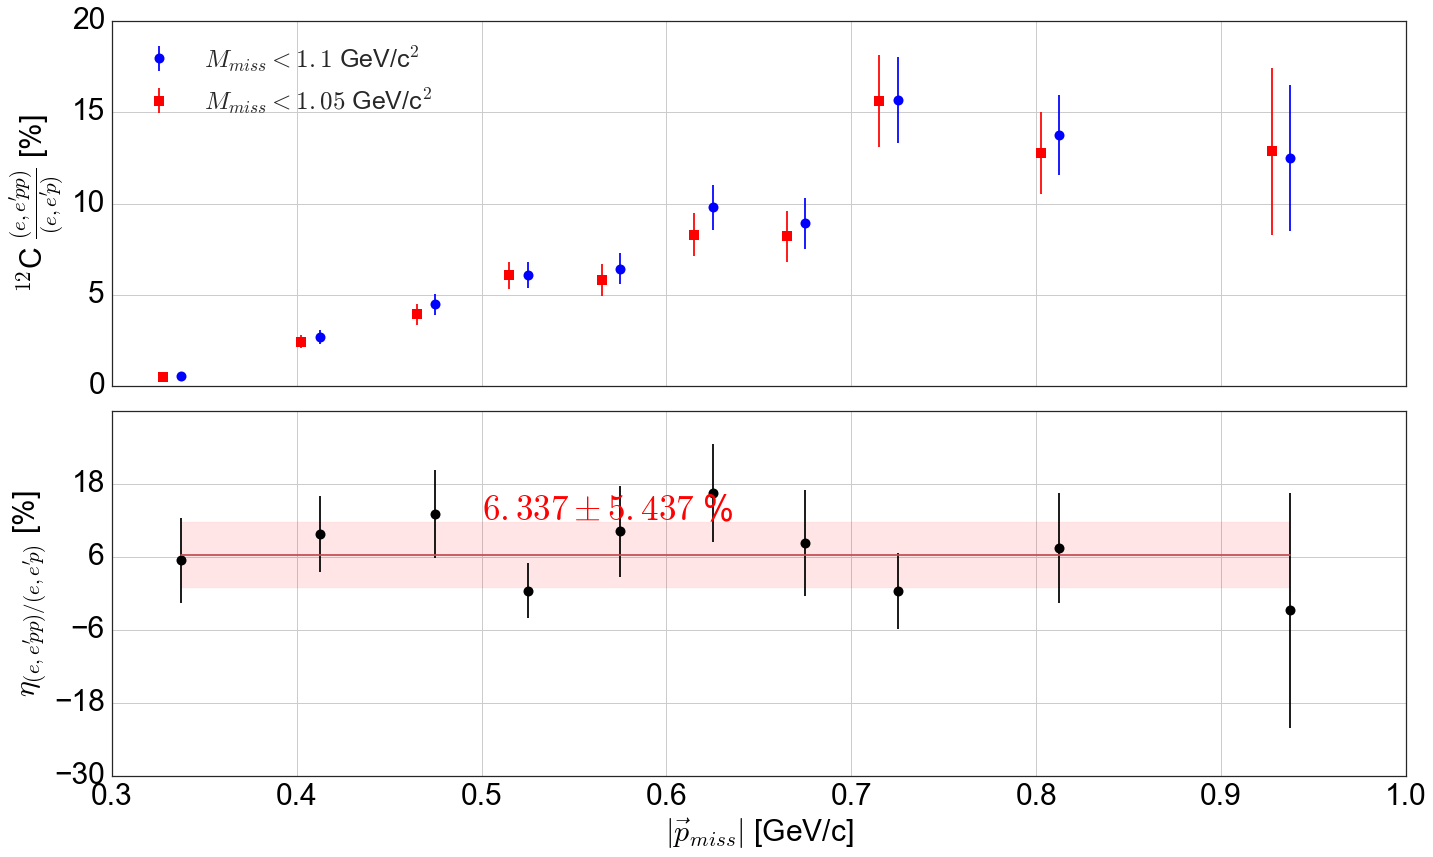

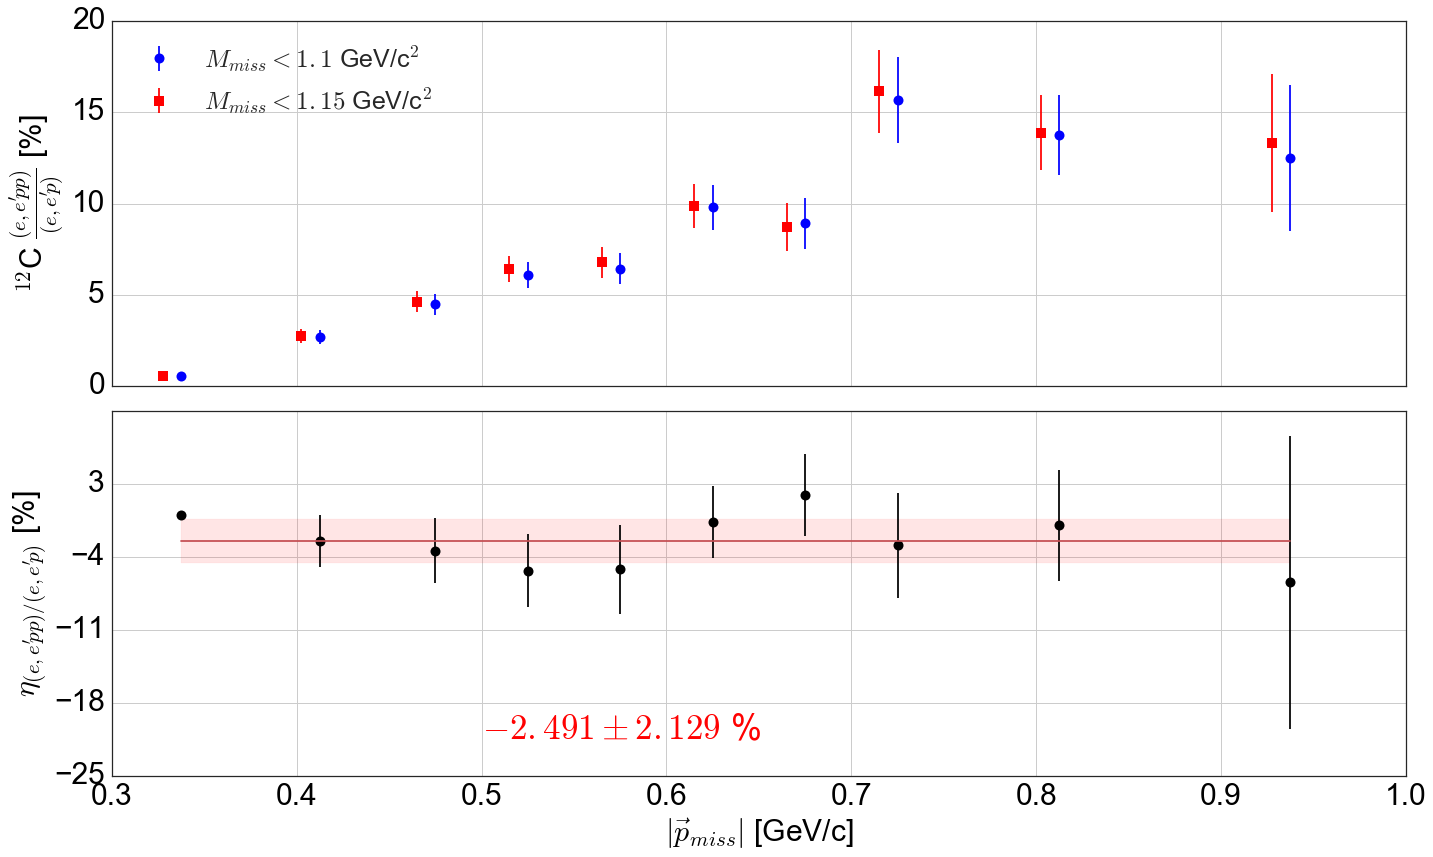

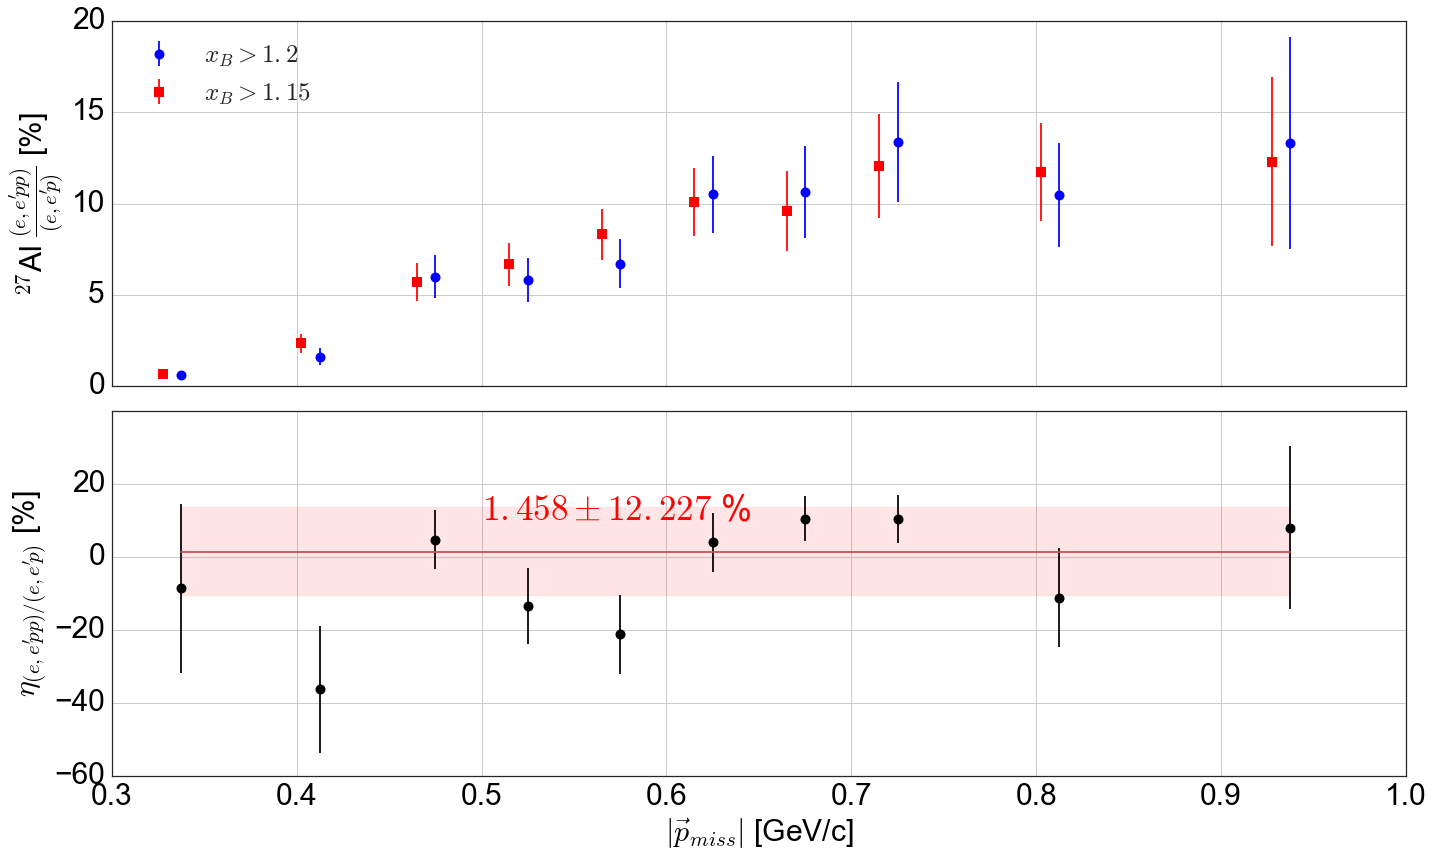

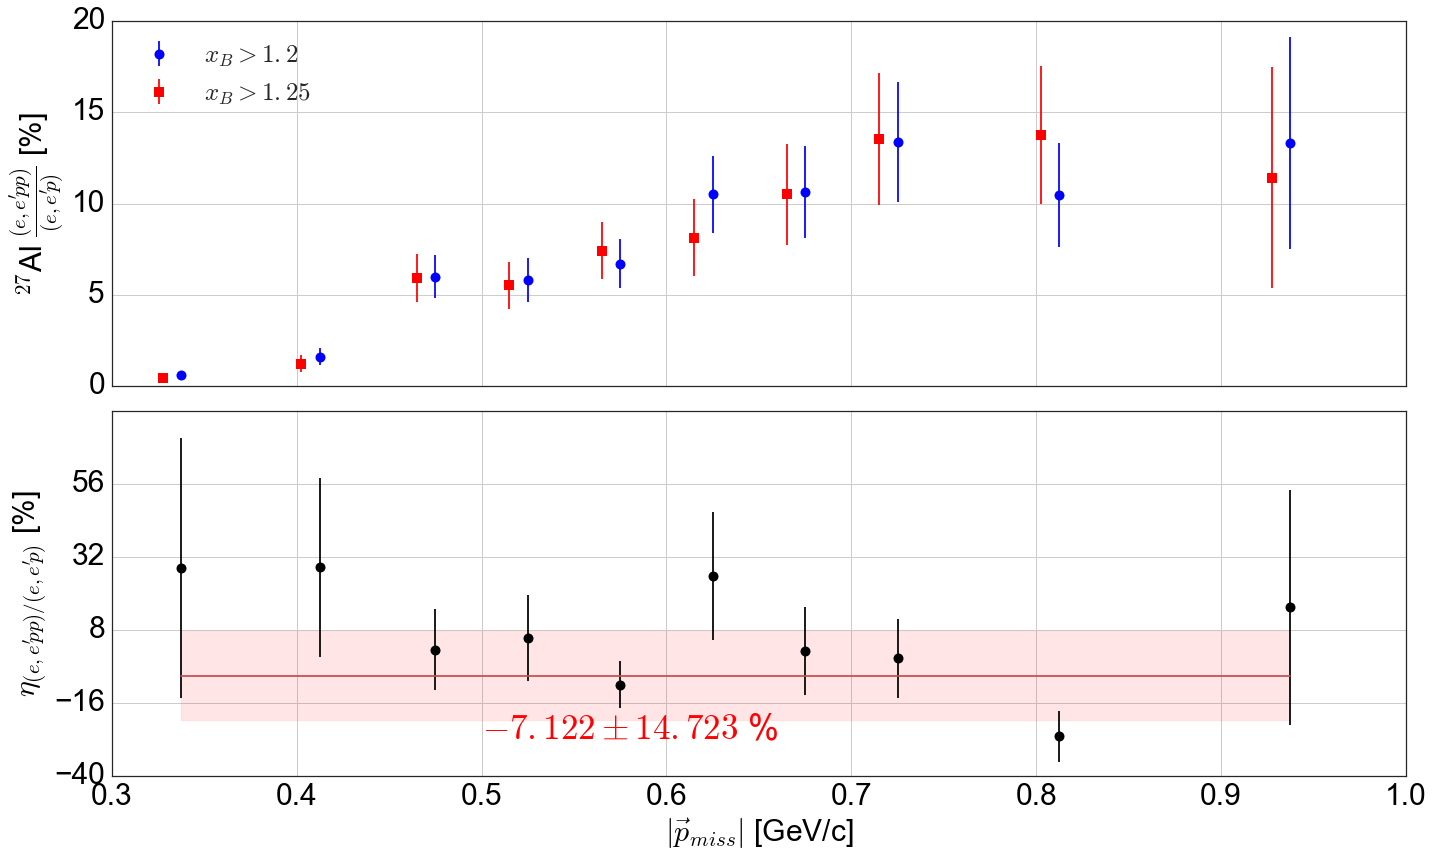

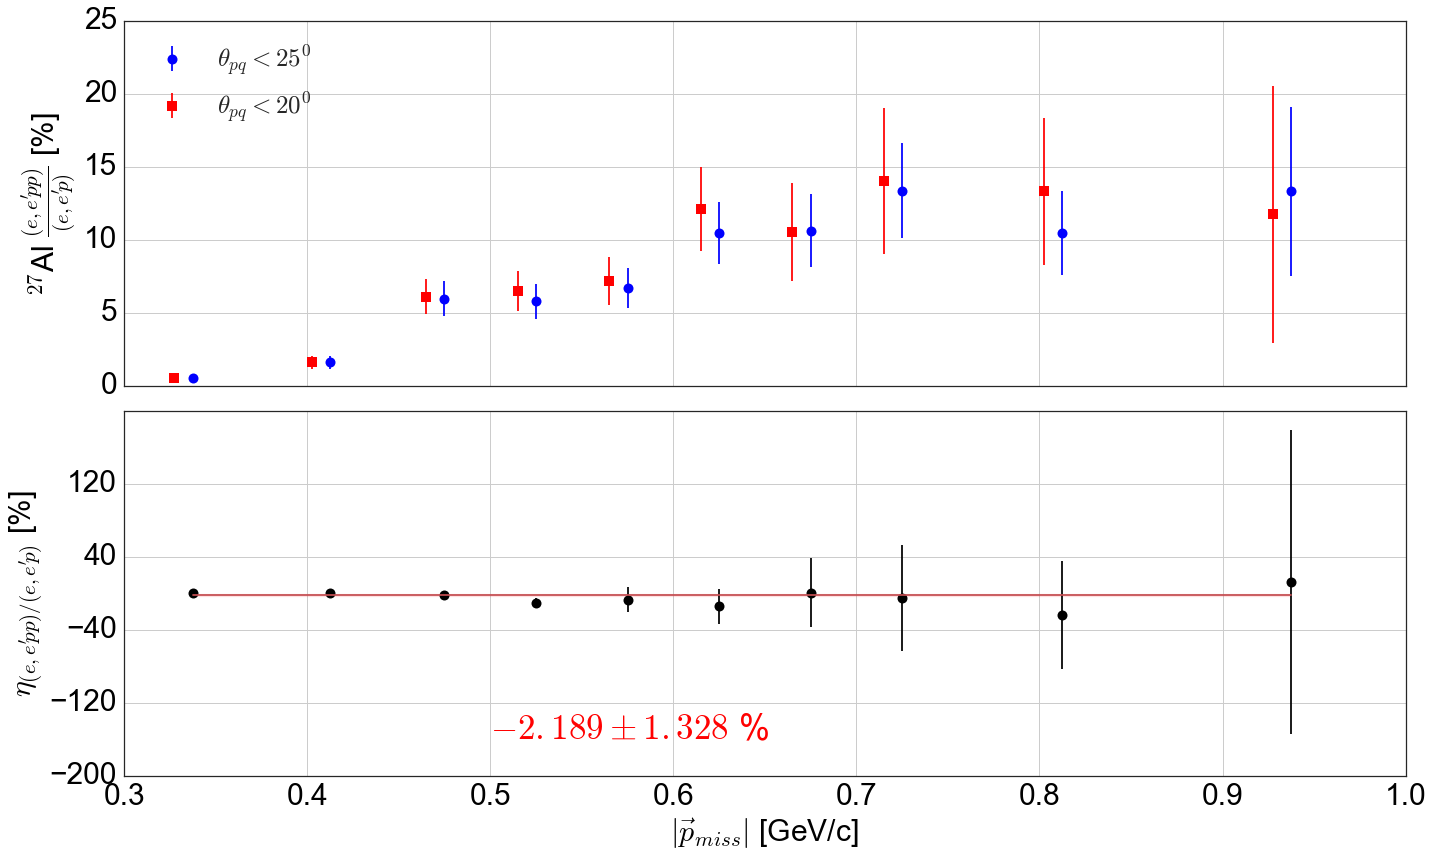

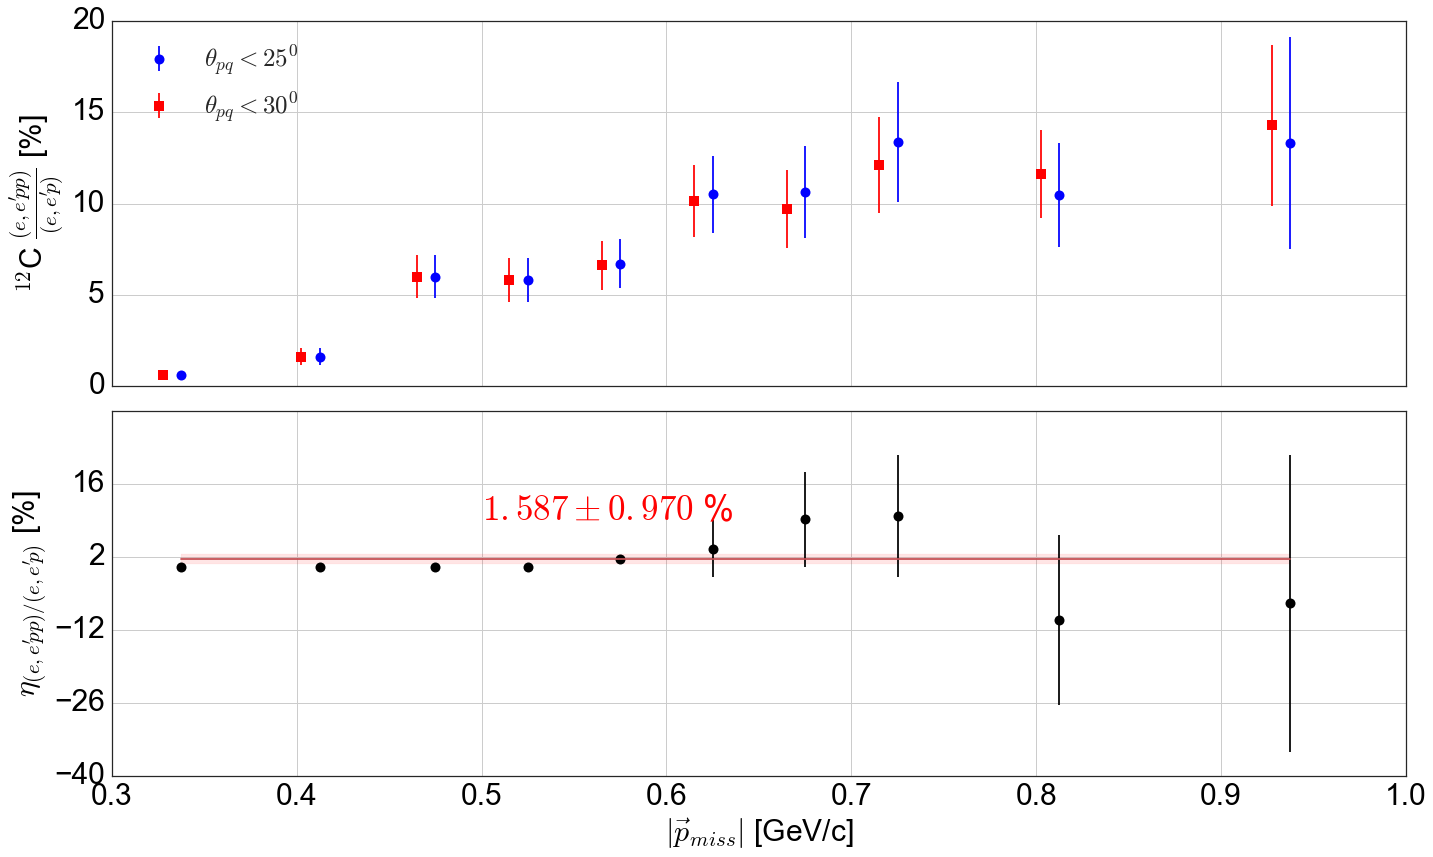

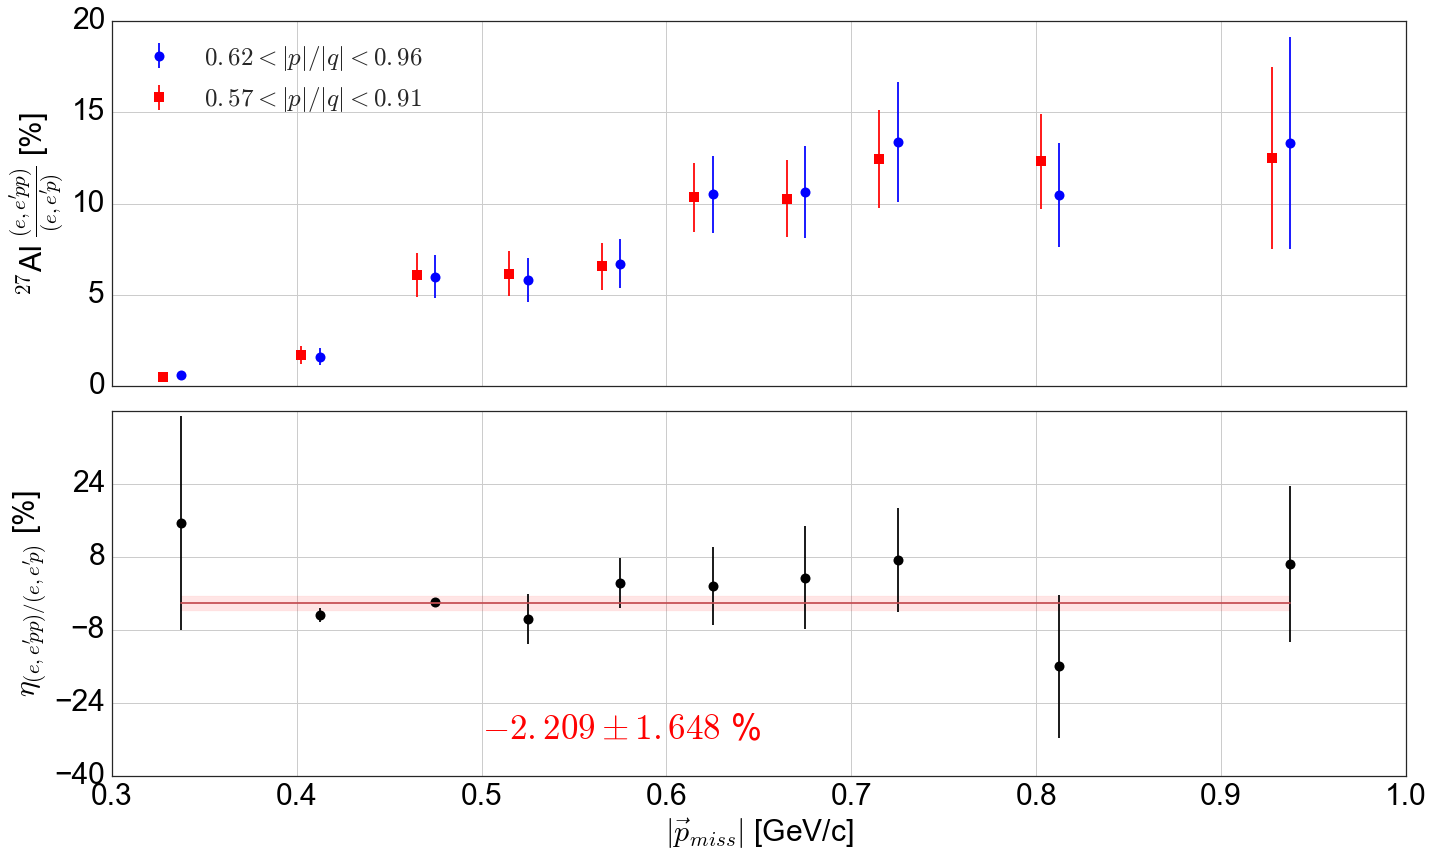

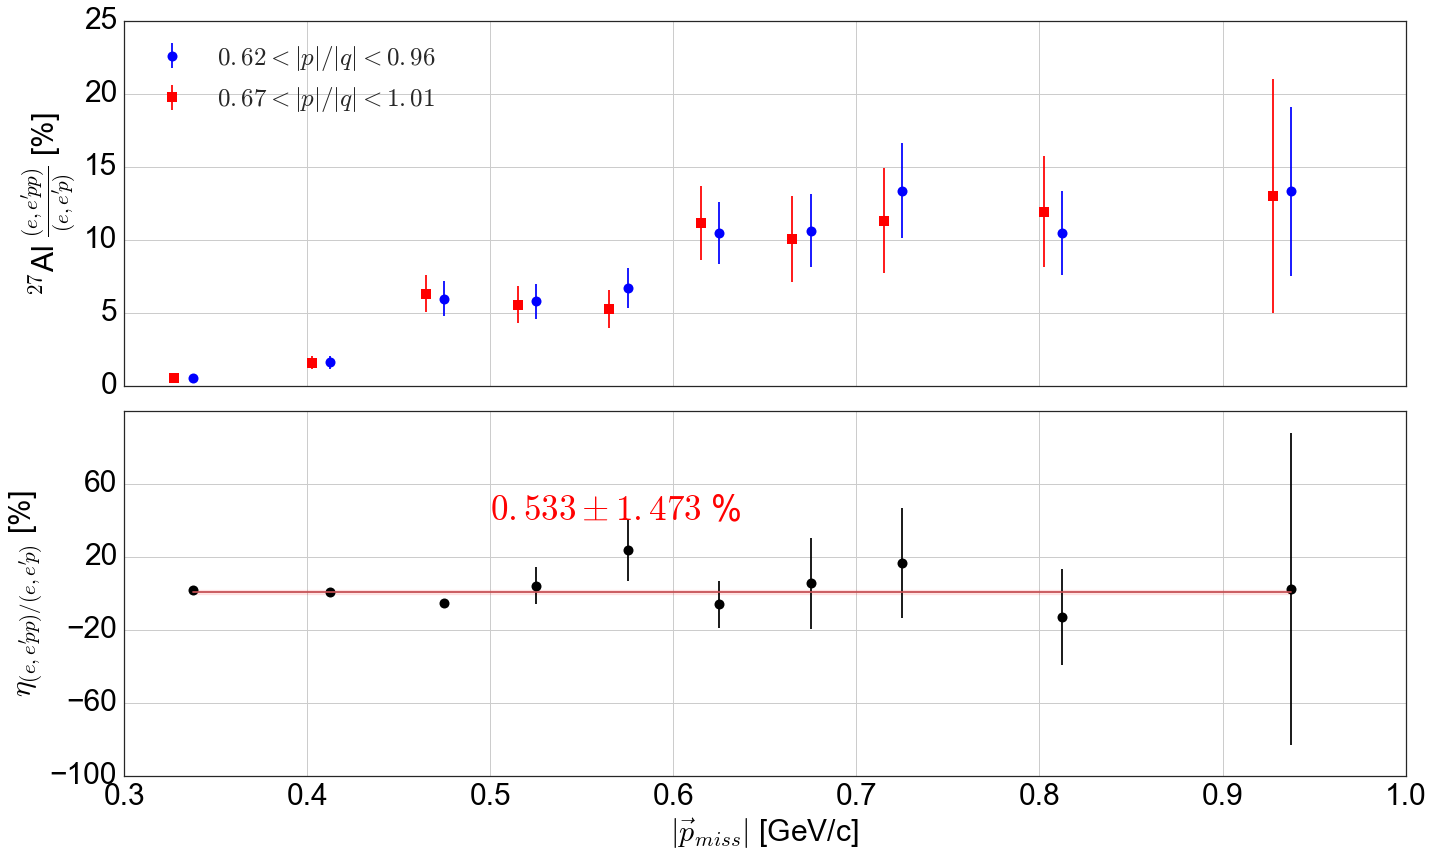

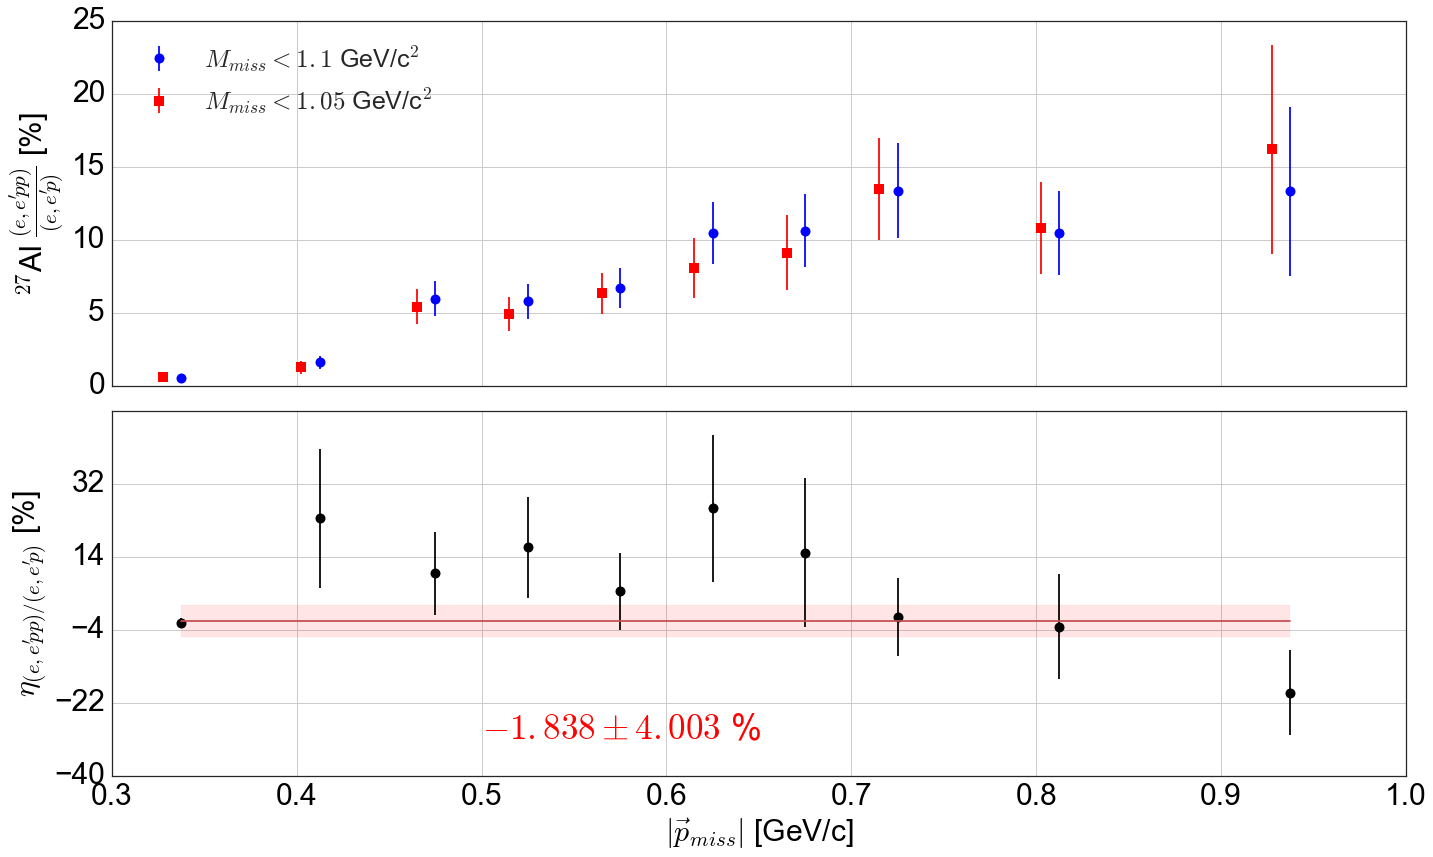

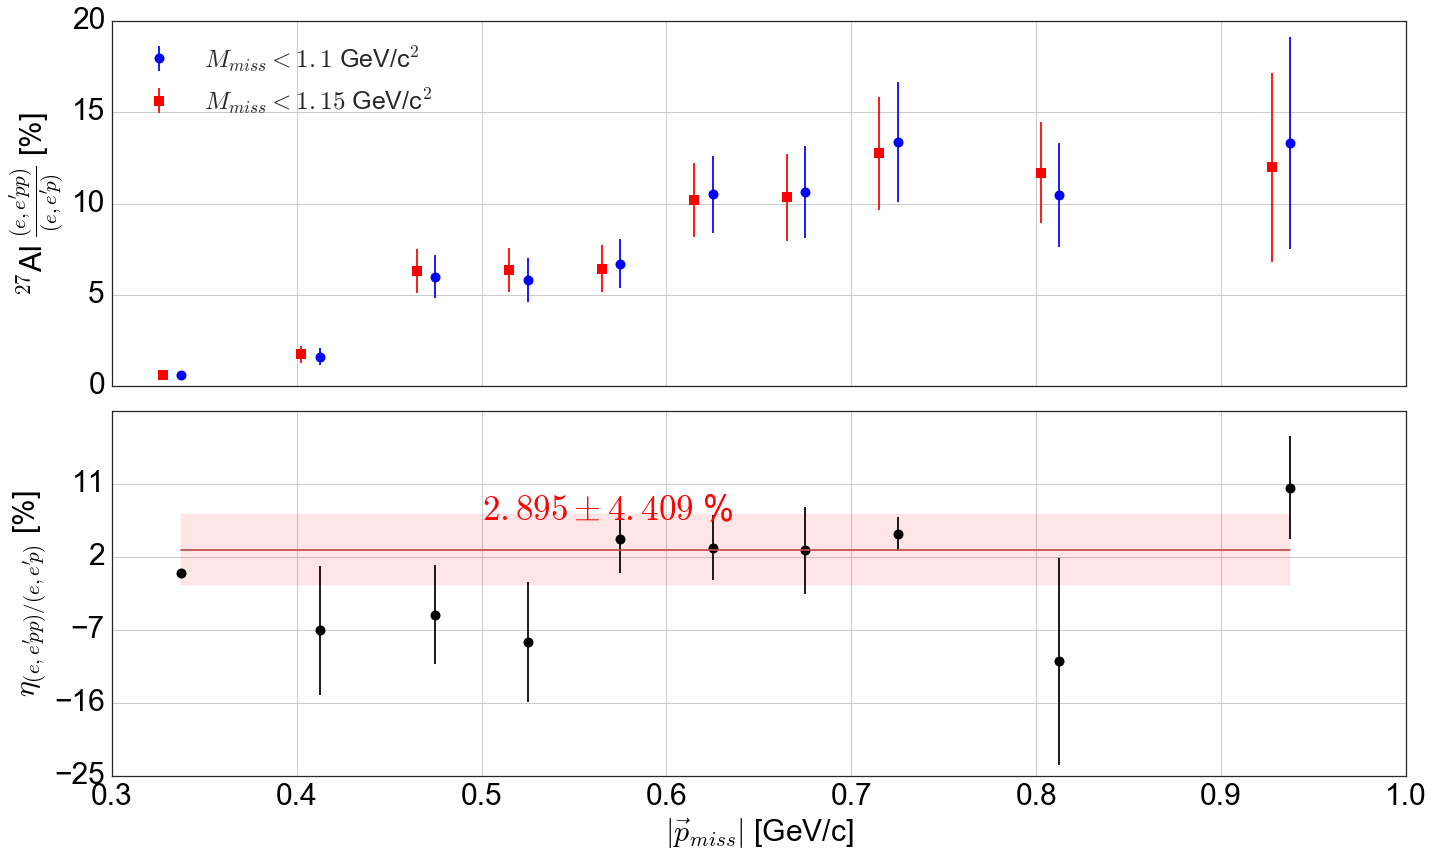

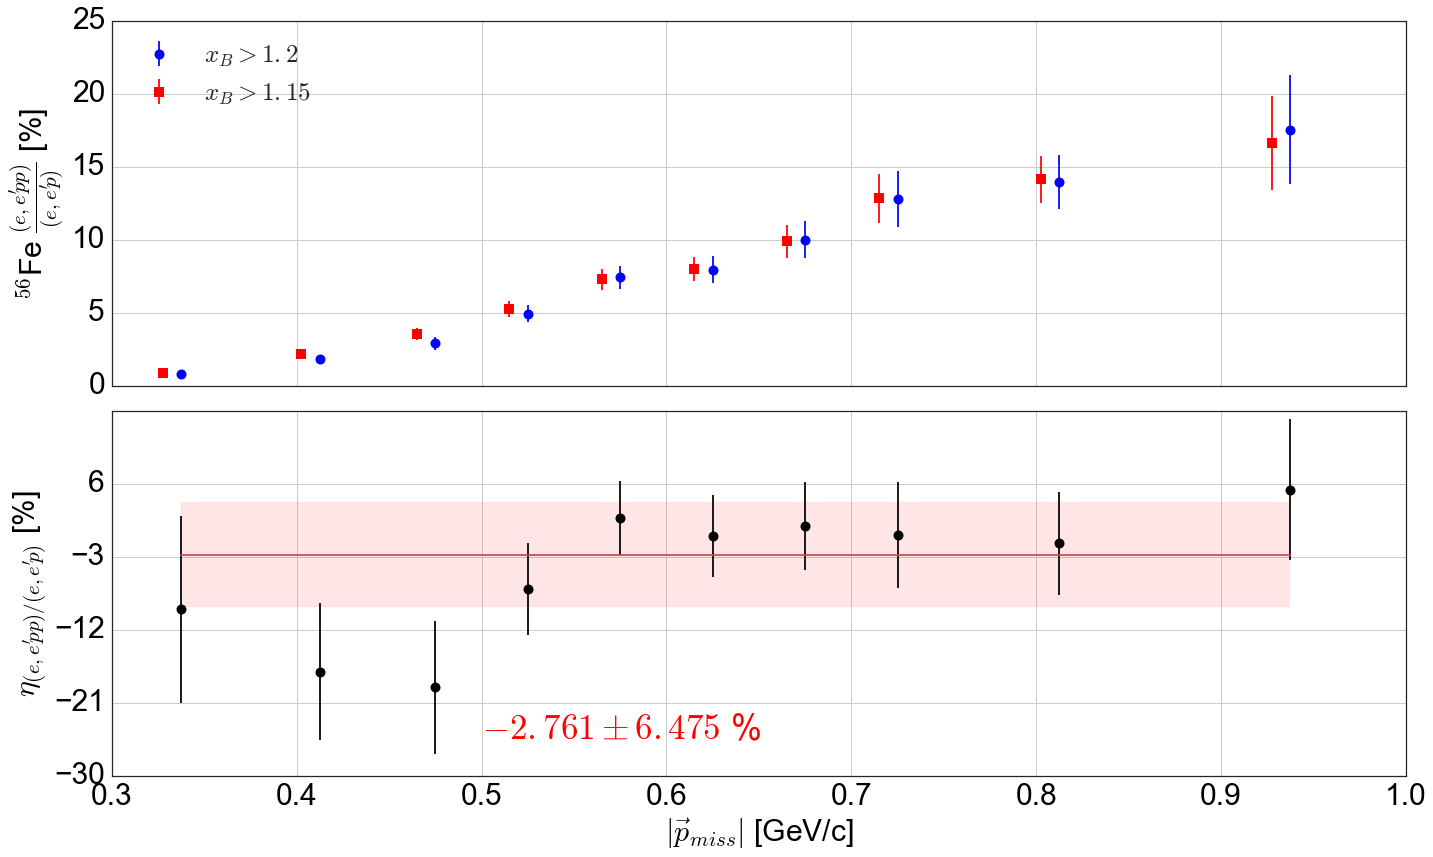

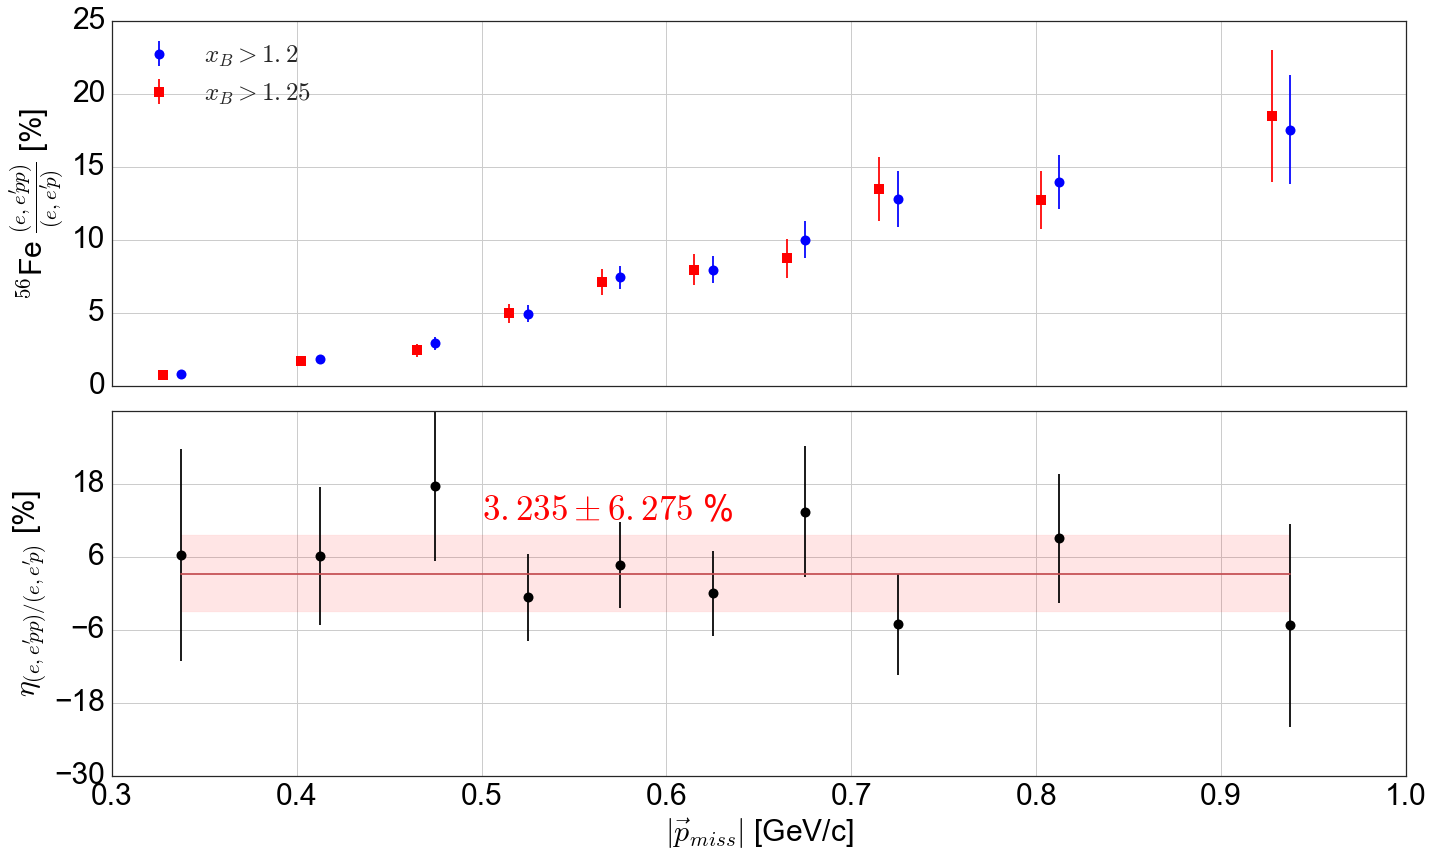

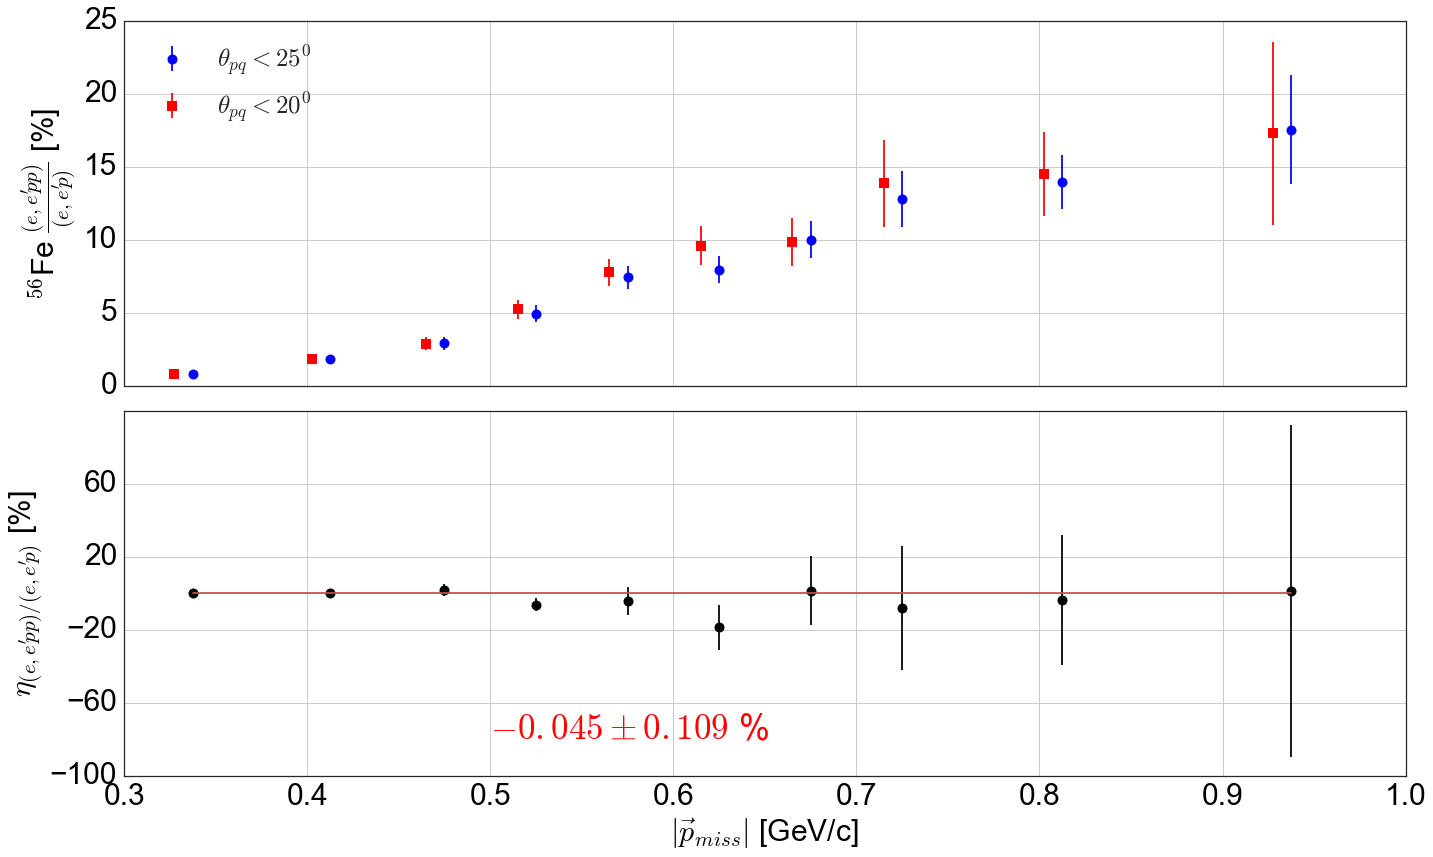

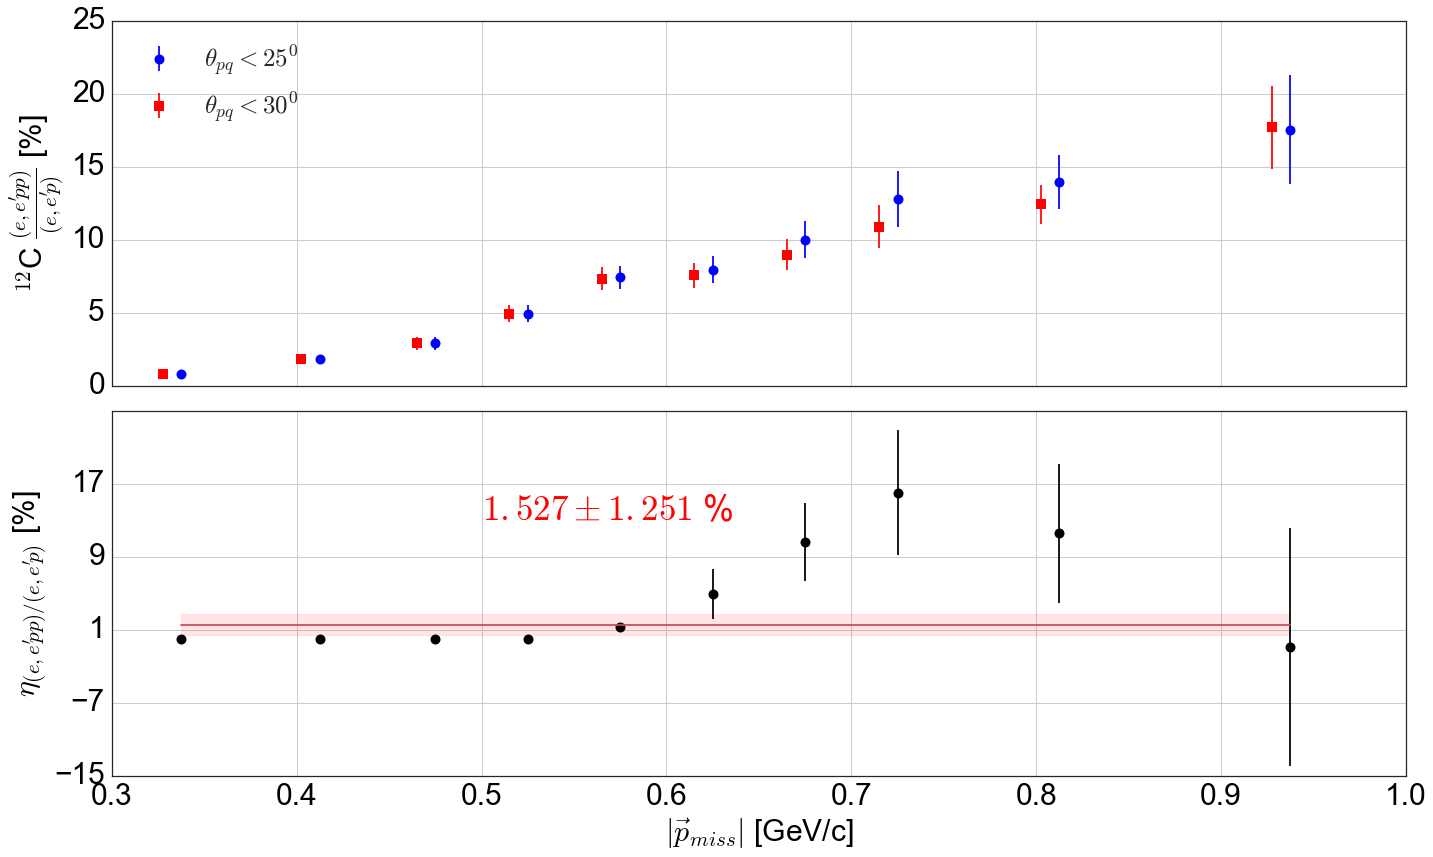

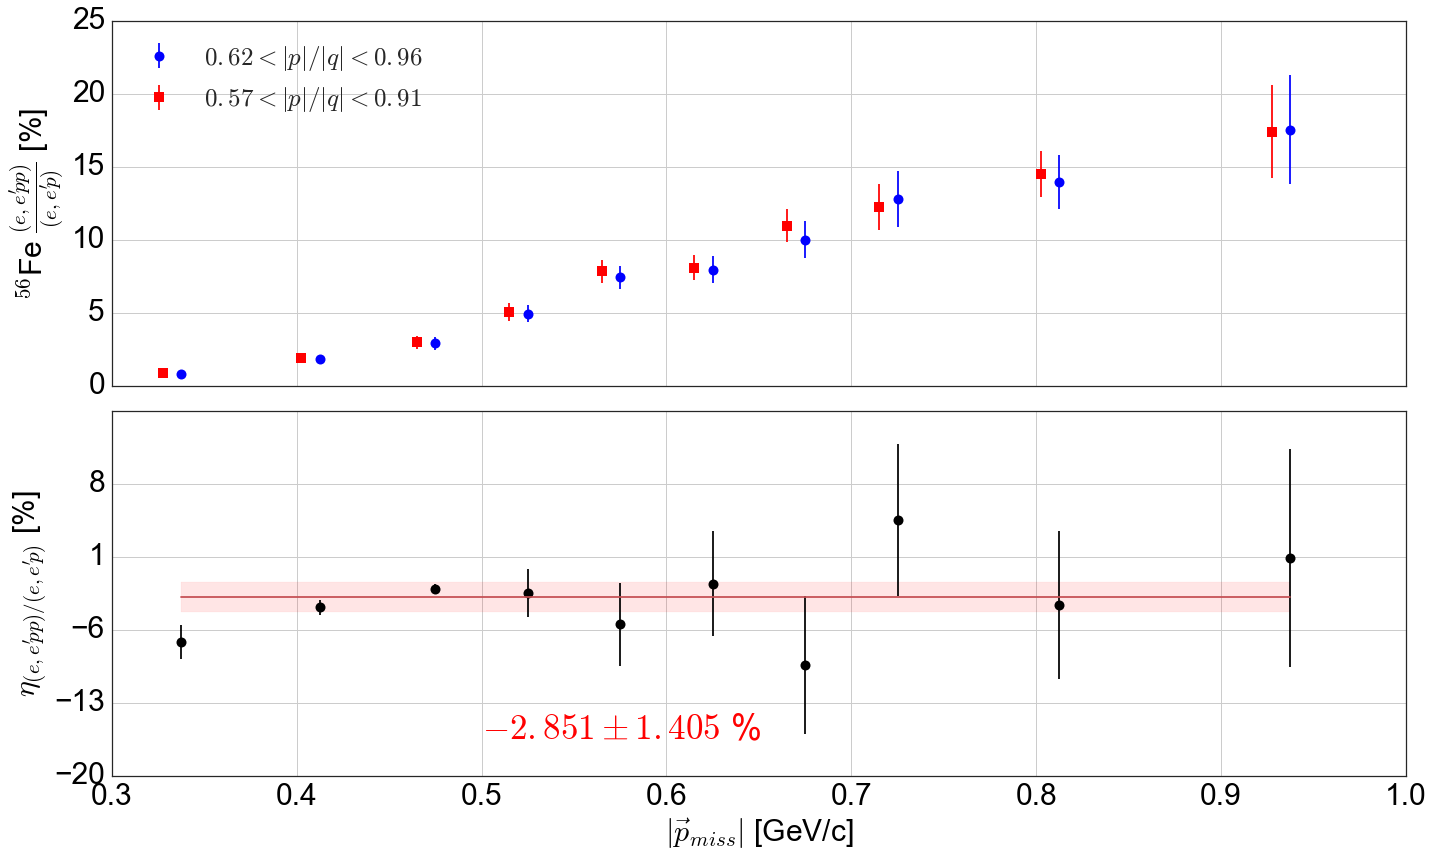

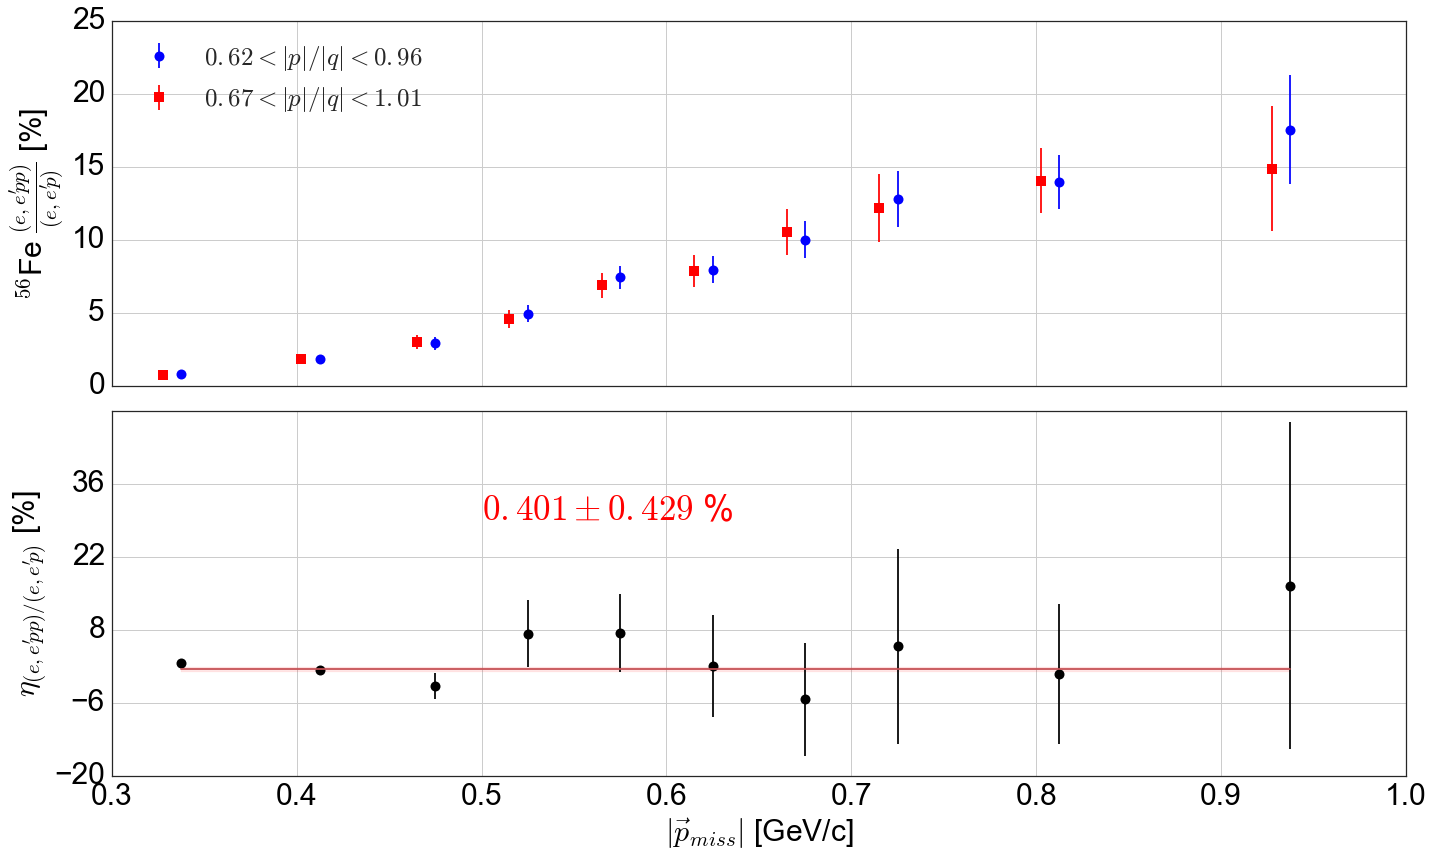

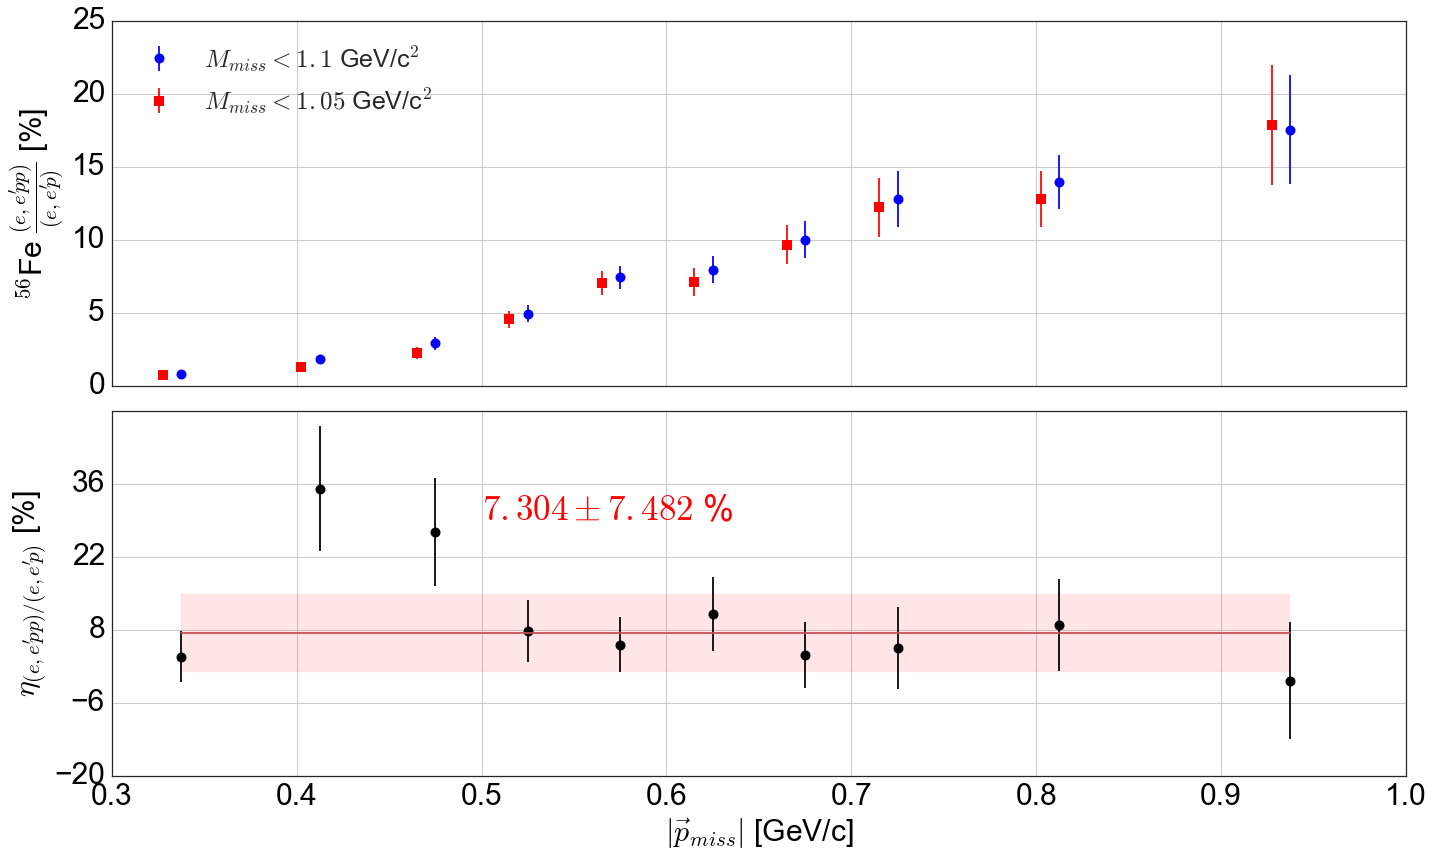

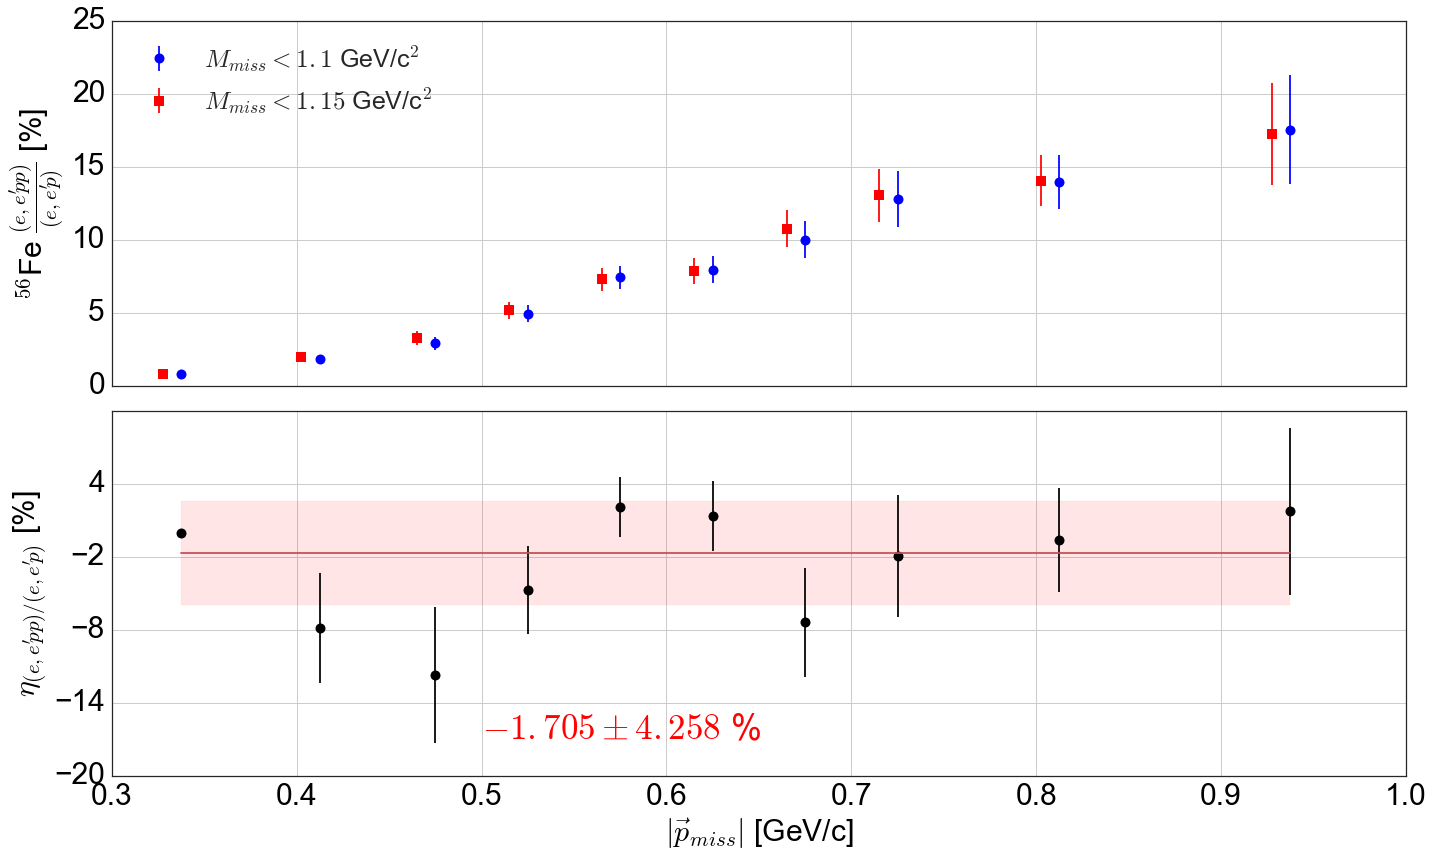

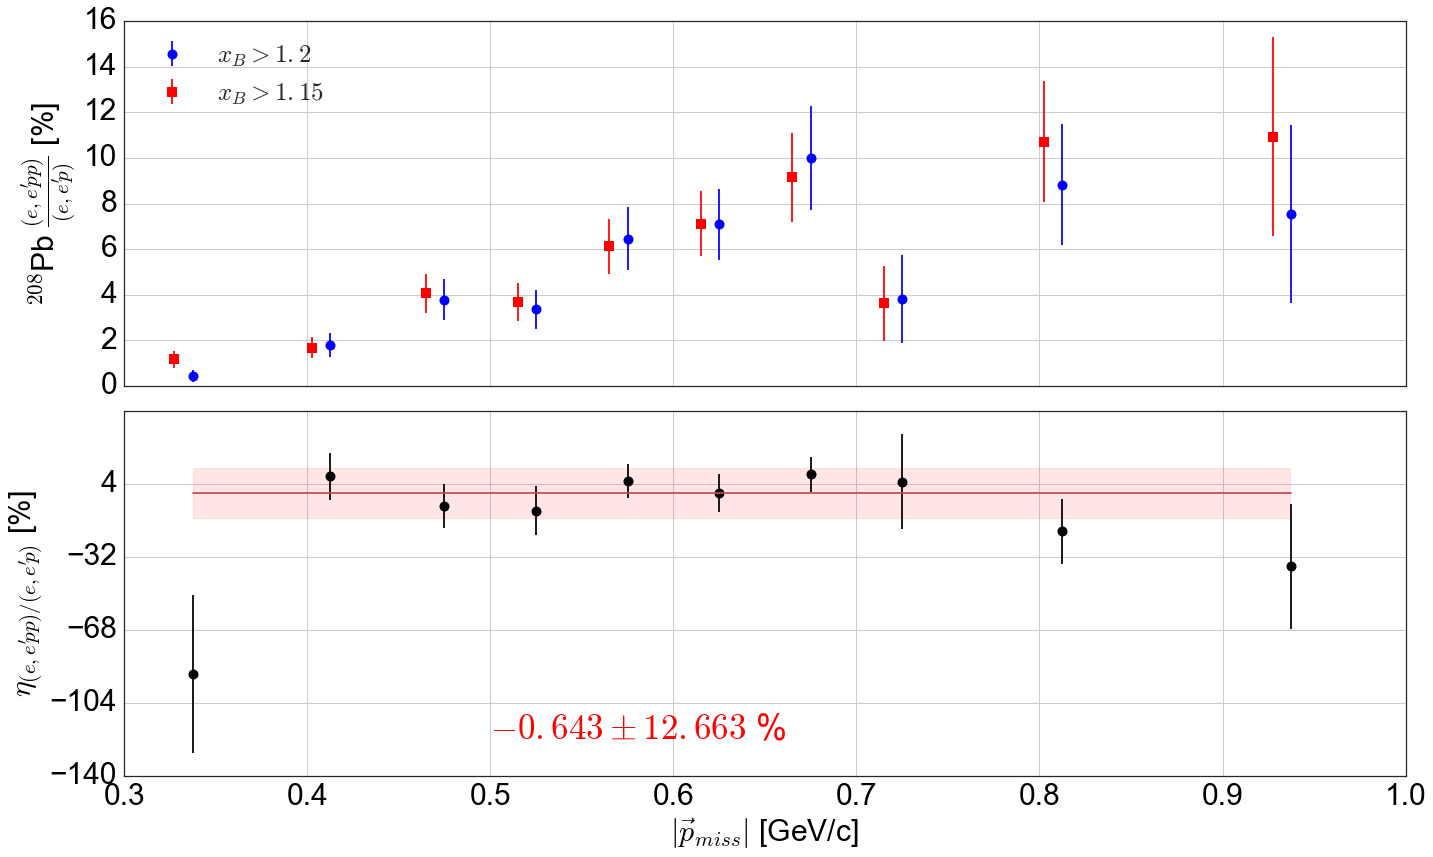

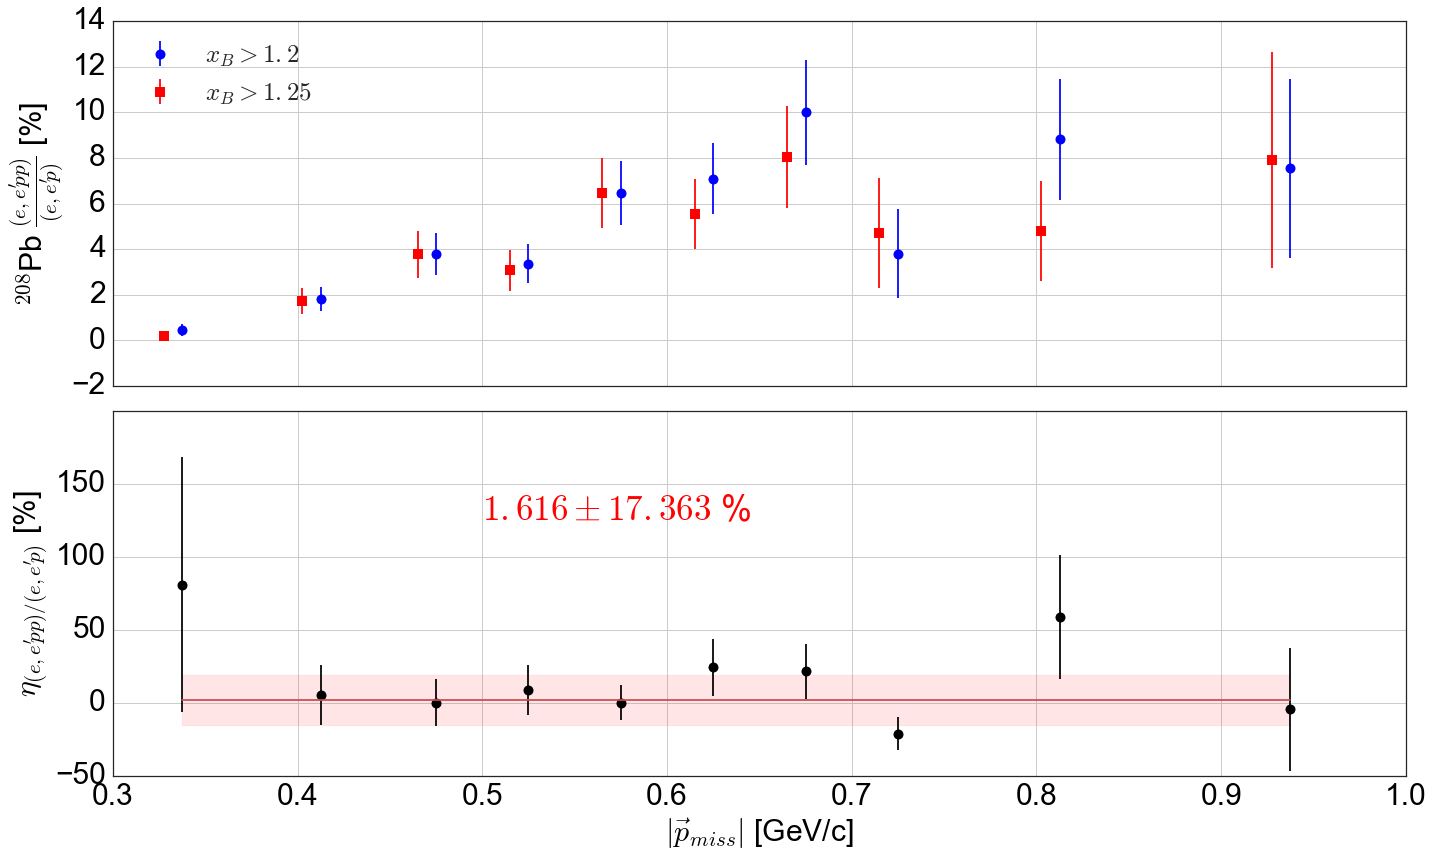

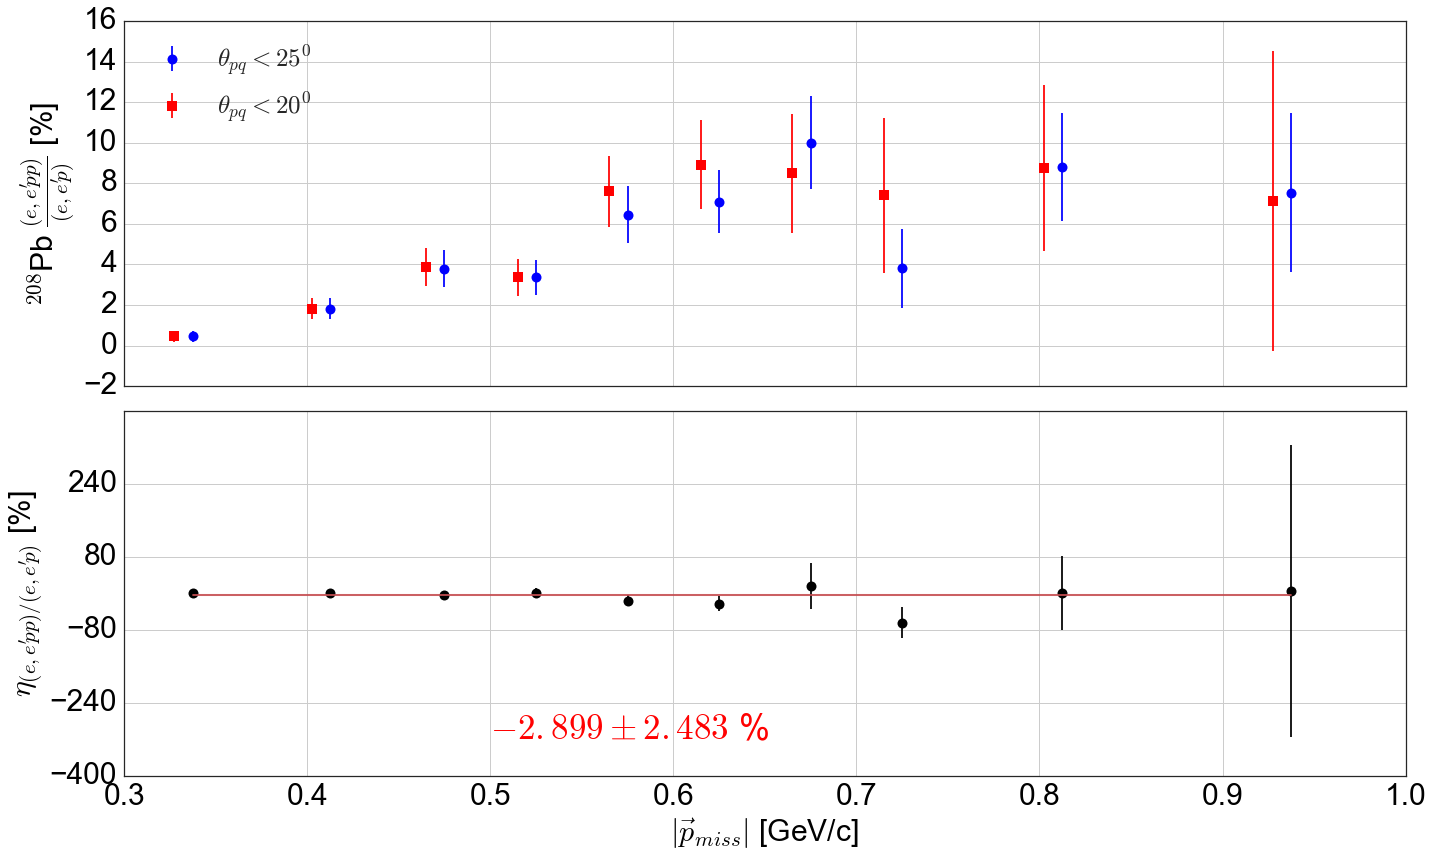

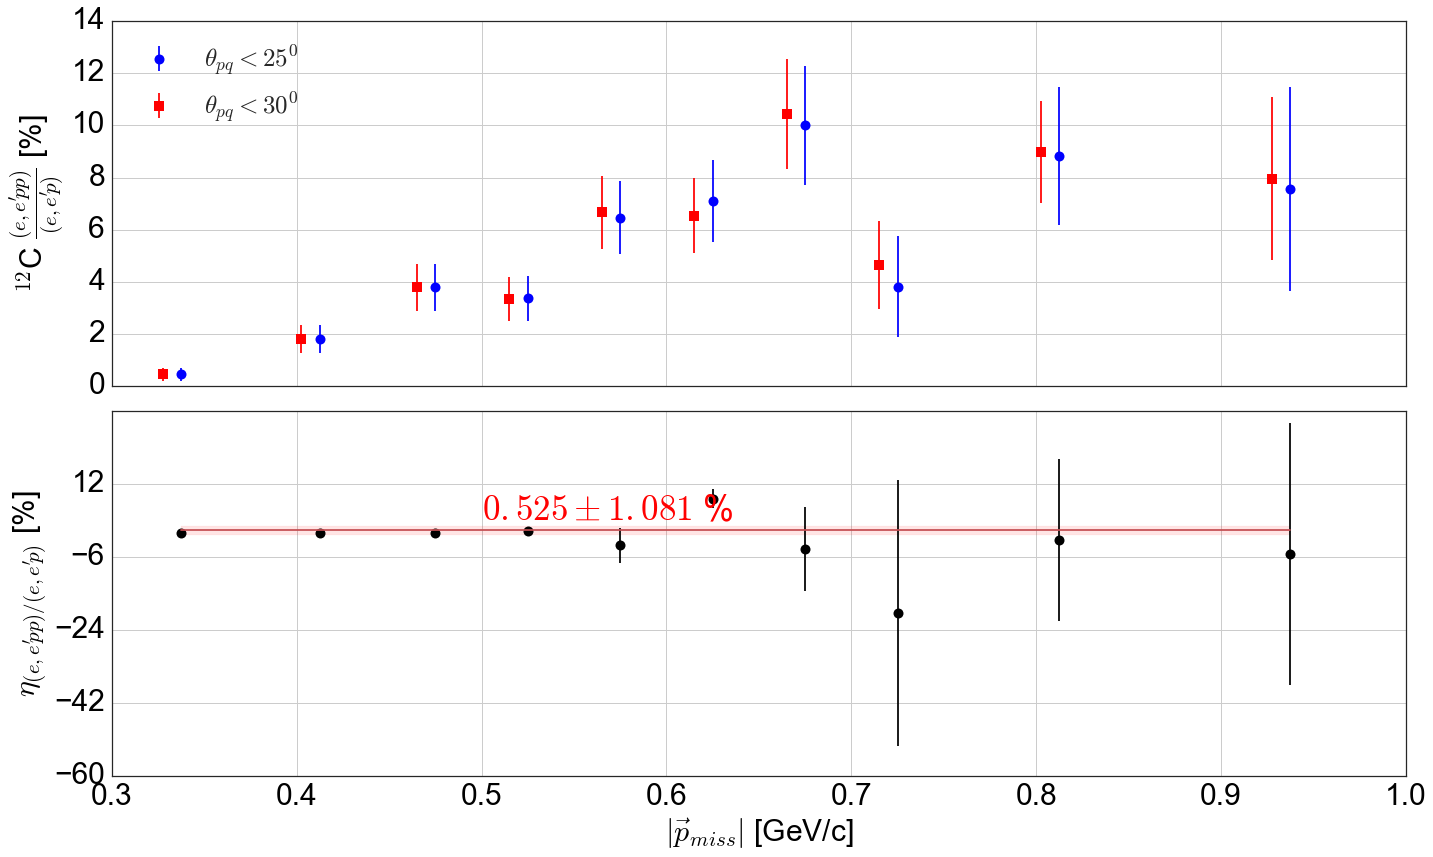

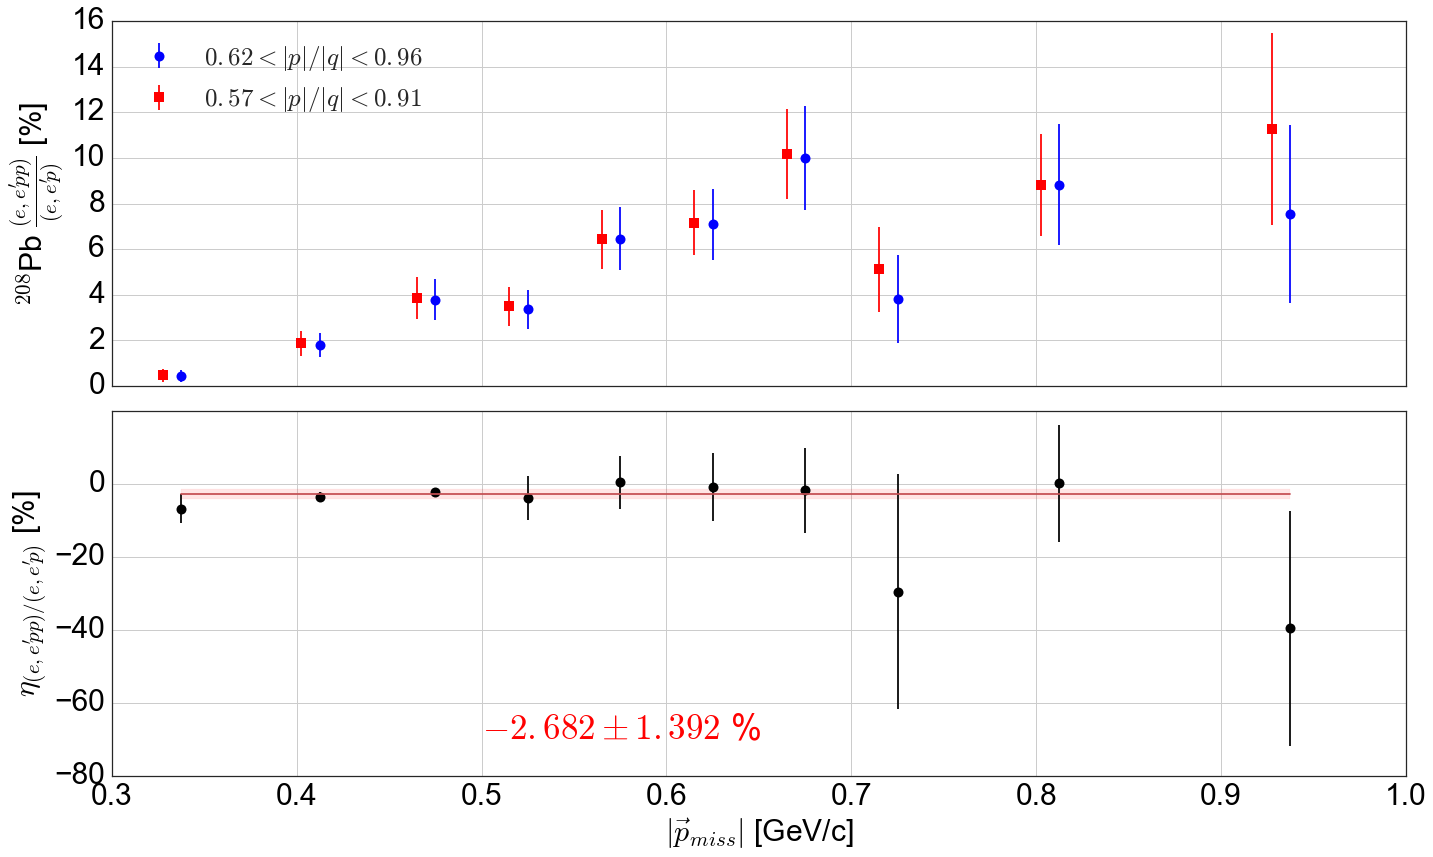

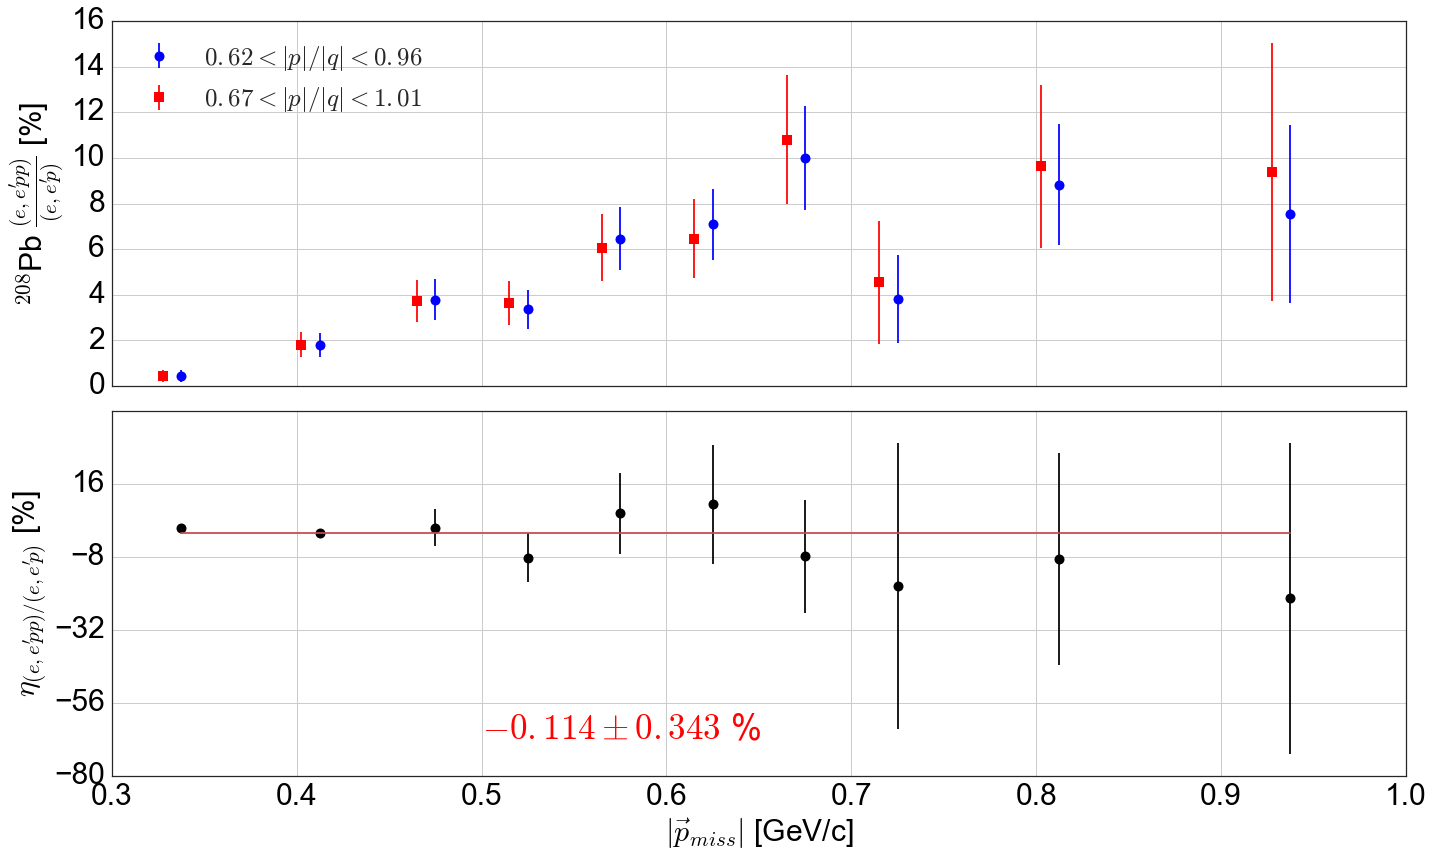

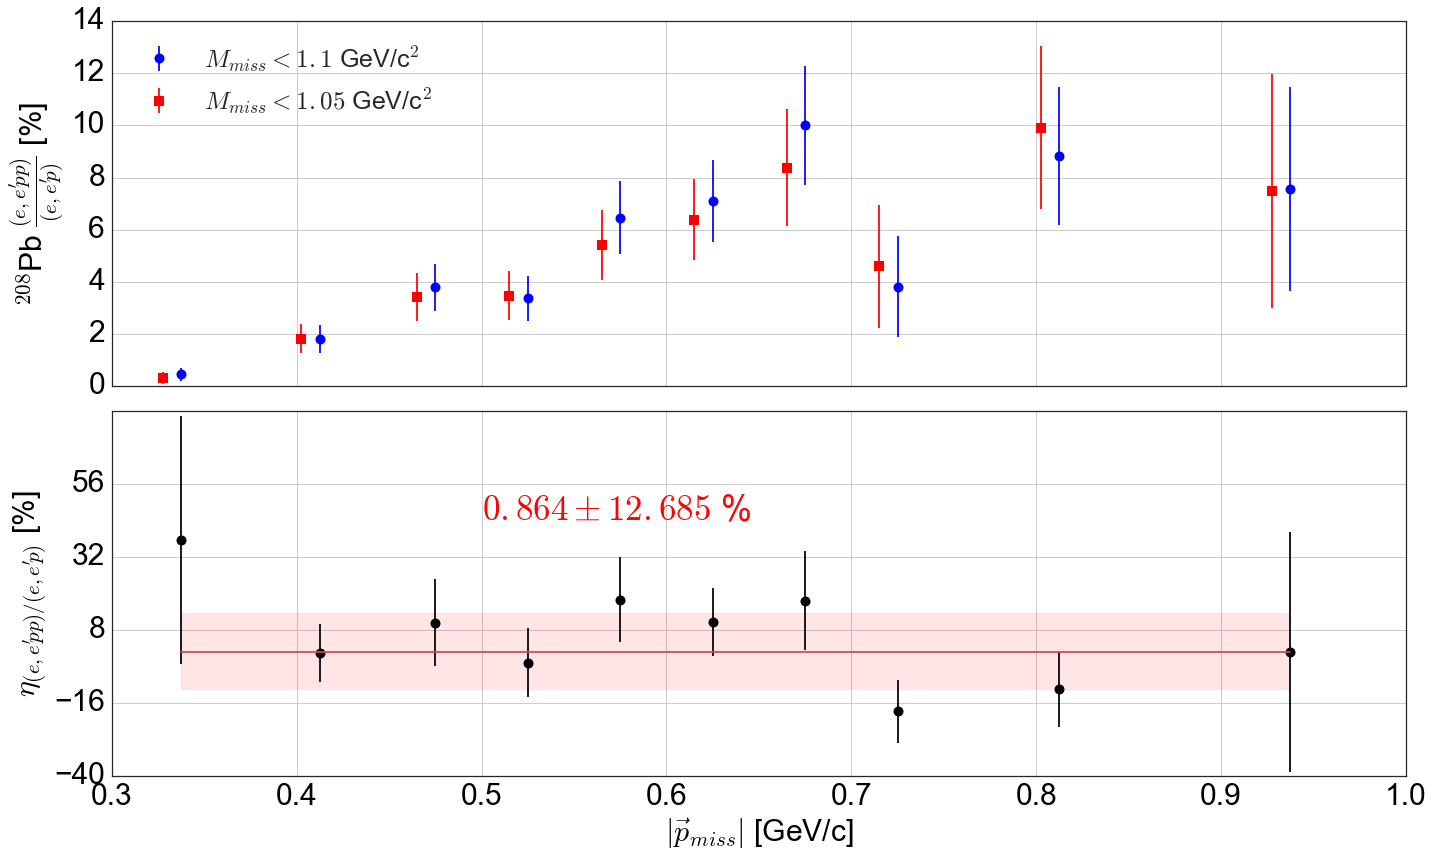

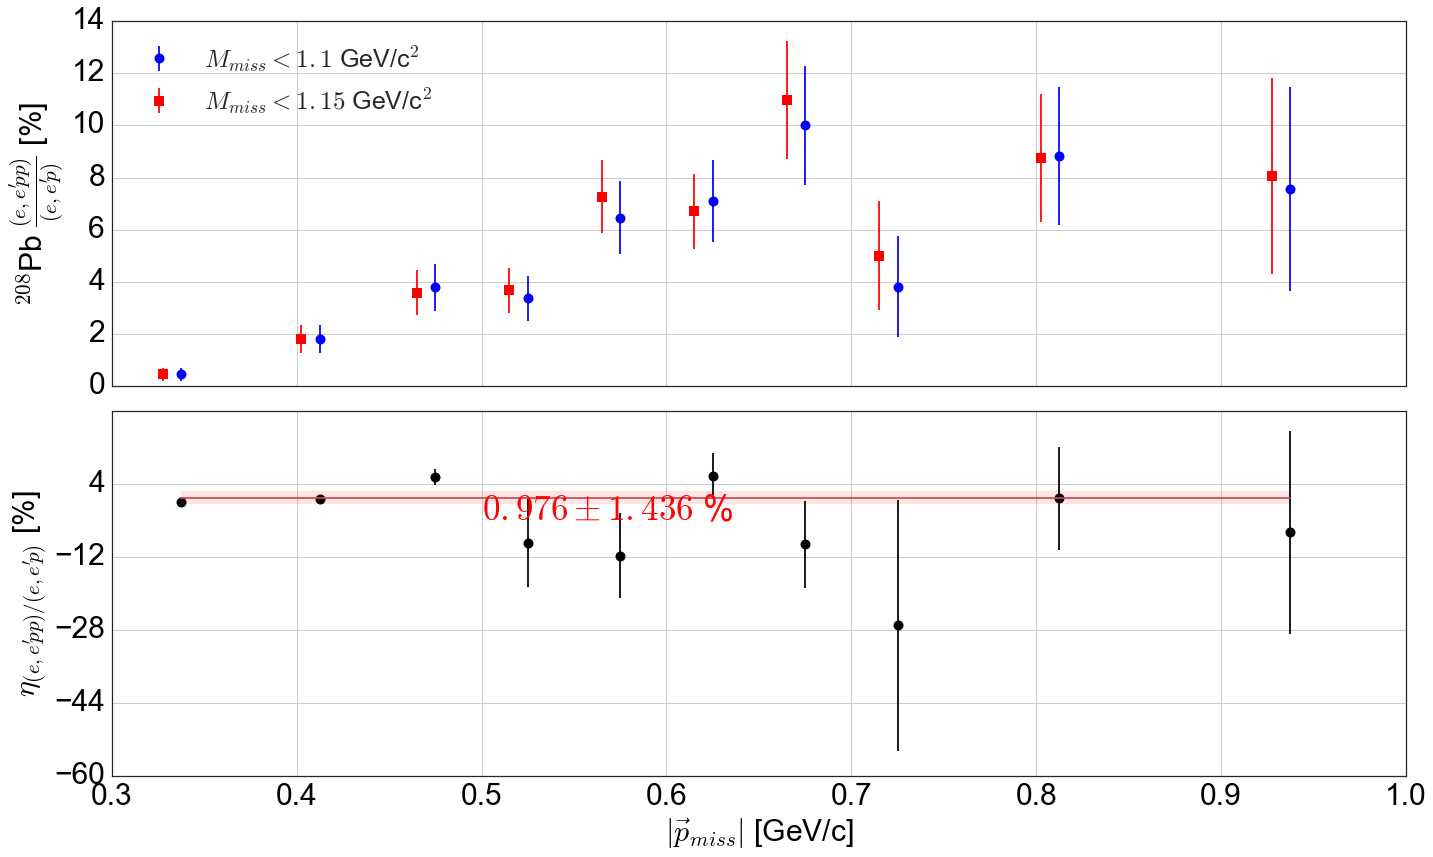

In [11]:
do_prints = False
do_make_plots=True
do_save_plots=True
targets = ['C12','Al27','Fe56','Pb208']
target_names = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']
for target,target_name in zip(targets,target_names ):
    print '\n',target,'\n-------------'
    a,a_err = modeified_eep_eepp(modified_cut_name='Xb115' ,
                                 nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$'],  
                                 cutXb = '(1.15<Xb)' , target=target,target_name=target_name,
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                              
                                 pmiss_bins=pmiss_analysis_bins)
    b,b_err = modeified_eep_eepp(modified_cut_name='Xb125' , 
                                 nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.25$'],
                                 cutXb = '(1.25<Xb)' ,  target=target,target_name=target_name,
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
                                 pmiss_bins=pmiss_analysis_bins)
    sensitivity_Xb = np.max(np.abs([a,b,a_err,b_err]))
#     print [a,b,a_err,b_err]
    print 'xB>1.2 cut sensitivity: %.3f'%sensitivity_Xb 
    
    a,a_err = modeified_eep_eepp(modified_cut_name='theta_pq_20' , 
                                 nominal_and_modified_cut_names=['$\\theta_{pq}<25^{0}$','$\\theta_{pq}<20^{0}$'],
                                 cut_theta_pq = '(theta_pq<20)', target=target,target_name=target_name,
                                 ytext=None,                                
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
                                 pmiss_bins=pmiss_analysis_bins)
    b,b_err = modeified_eep_eepp(modified_cut_name='theta_pq_30' , 
                                 nominal_and_modified_cut_names=['$\\theta_{pq}<25^{0}$','$\\theta_{pq}<30^{0}$'],
                                 cut_theta_pq = '(theta_pq<30)', target=target,
#                                  ytext=-20,                                
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
                                 pmiss_bins=pmiss_analysis_bins)
    sensitivity_theta_pq = np.max(np.abs([a,b,a_err,b_err]))
#     print [a,b,a_err,b_err]
    print 'theta_pq<25 cut sensitivity: %.2f'%sensitivity_theta_pq

    a,a_err = modeified_eep_eepp(modified_cut_name='p_over_q_057_091' , 
                                 nominal_and_modified_cut_names=['$0.62<|p|/|q|<0.96$','$0.57<|p|/|q|<0.91$'],
                                 cut_p_over_q = '(0.57<p_over_q && p_over_q<0.91)', target=target,target_name=target_name,
#                                  ytext=1.3,                                
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
                                 pmiss_bins=pmiss_analysis_bins)
    b,b_err = modeified_eep_eepp(modified_cut_name='p_over_q_067_101' , 
                                 nominal_and_modified_cut_names=['$0.62<|p|/|q|<0.96$','$0.67<|p|/|q|<1.01$'],
                                 cut_p_over_q = '(0.67<p_over_q && p_over_q<1.01)', target=target,target_name=target_name,
#                                  ytext=-30,                                
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
                                 pmiss_bins=pmiss_analysis_bins)
    sensitivity_p_over_q = np.max(np.abs([a,b,a_err,b_err]))
#     print [a,b,a_err,b_err]
    print 'p/q<25 cut sensitivity: %.3f'%sensitivity_p_over_q


    a,a_err = modeified_eep_eepp(modified_cut_name='mmiss1050' , 
                                 nominal_and_modified_cut_names=['$M_{miss}<1.1$ GeV/c$^2$','$M_{miss}<1.05$ GeV/c$^2$'],
                                 cut_m_miss = 'Mmiss < 1.050', target=target,target_name=target_name,
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,   
#                                  ytext=-18,
                                 pmiss_bins=pmiss_analysis_bins)
    b,b_err = modeified_eep_eepp(modified_cut_name='mmiss1150' , 
                                 nominal_and_modified_cut_names=['$M_{miss}<1.1$ GeV/c$^2$','$M_{miss}<1.15$ GeV/c$^2$'],
                                 cut_m_miss = 'Mmiss < 1.150', target=target,target_name=target_name,
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
                                 pmiss_bins=pmiss_analysis_bins)
    sensitivity_m_miss = np.max(np.abs([a,b,a_err,b_err]))
#     print [a,b,a_err,b_err]
    print 'Mmiss < 1.1 cut sensitivity: %.3f'%sensitivity_m_miss
    sensitivity = np.sqrt( sensitivity_Xb*sensitivity_Xb 
                          + sensitivity_theta_pq*sensitivity_theta_pq
                          + sensitivity_p_over_q*sensitivity_p_over_q 
                          + sensitivity_m_miss*sensitivity_m_miss )
    print 'tot. syst. uncertainty due to the event selection cut: %.3f'%sensitivity




# older versions... (all targets)

(-0.012014085139617638, 0.047907611499962019)

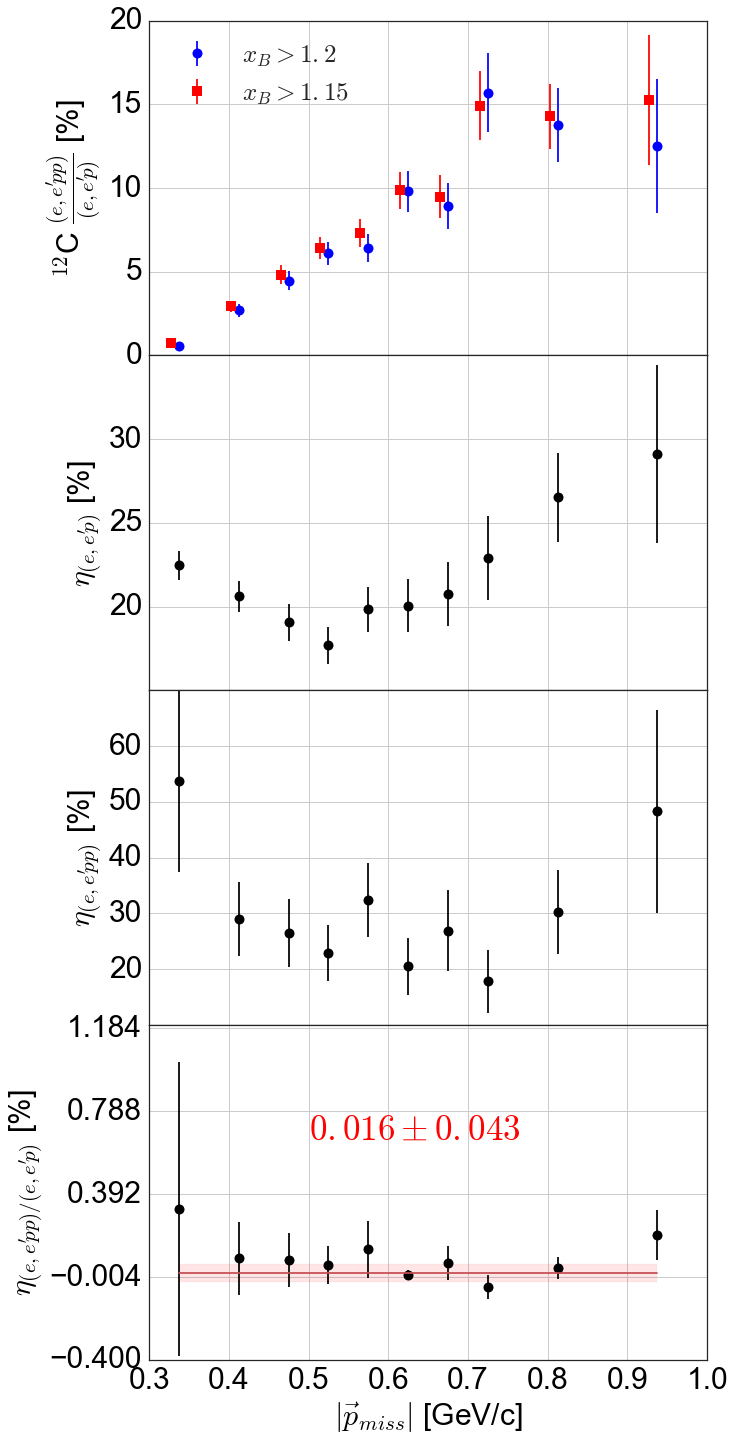

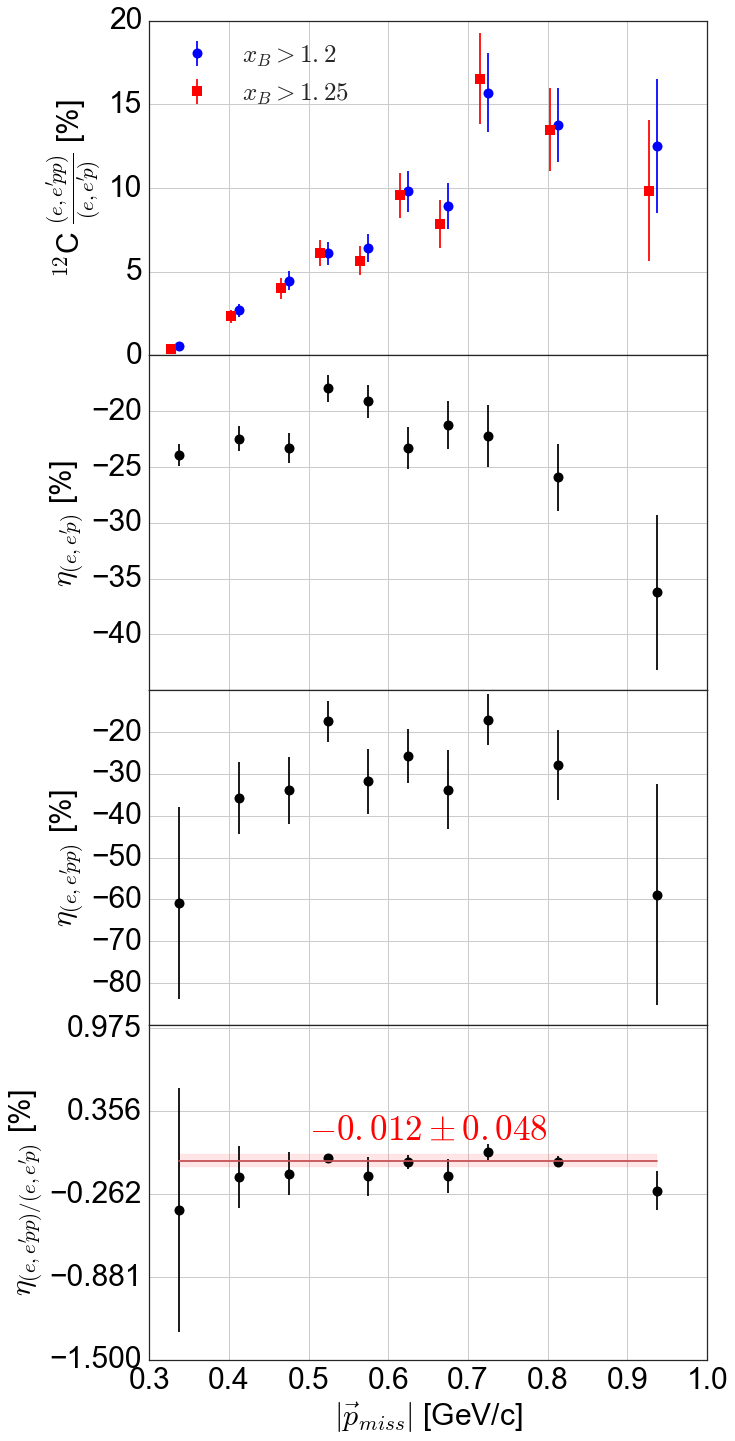

In [14]:
modeified_eep_eepp(modified_cut_name='Xb' ,nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$'],                                                            
                   target='C12',target_name='$^{12}$C',                                     
                   cutXb = '1.15<Xb',
                   pmiss_bins=pmiss_analysis_bins,
                   do_make_plots=True#,ytext=20
                  )
modeified_eep_eepp(modified_cut_name='Xb' ,nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.25$'],                                                            
                   target='C12',target_name='$^{12}$C',                                     
                   cutXb = '1.25<Xb',
                   pmiss_bins=pmiss_analysis_bins,
                   do_make_plots=True#,ytext=-30
                  )

In [7]:
do_make_plots=True
do_save_plots=True
for target,target_name in zip(['C12']#,'Al27','Fe56','Pb208']
                              ,['$^{12}$C']#,'$^{27}$Al','$^{56}$Fe','$^{208}$Pb']
                             ):
    print '\n',target,'\n-------------'
    a,a_err = modeified_cut_eepp_eep_ratio(modified_cut_name='Xb115' ,
                                 nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$'],  
                                 cutXb = '(1.15<Xb)' , target=target,target_name=target_name,
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                              
                                 pmiss_bins=pmiss_analysis_bins)
    b,b_err = modeified_cut_eepp_eep_ratio(modified_cut_name='Xb125' , 
                                 nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.25$'],
                                 cutXb = '(1.25<Xb)' ,  target=target,target_name=target_name,
                                 do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
                                 pmiss_bins=pmiss_analysis_bins)
    print [a,b,a_err,b_err]
    print 'xB>1.2 cut sensitivity: %.1f'%np.max(np.abs([a,b,a_err,b_err])) + '%'
    
#     a,a_err = modeified_cut_eepp_eep_ratio(modified_cut_name='theta_pq_20' , 
#                                  nominal_and_modified_cut_names=['$\\theta_{pq}<25^{0}$','$\\theta_{pq}<20^{0}$'],
#                                  cut_theta_pq = '(theta_pq<20)', target=target,target_name=target_name,
#                                  ytext=None,                                
#                                  do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
#                                  pmiss_bins=pmiss_analysis_bins)
#     b,b_err = modeified_cut_eepp_eep_ratio(modified_cut_name='theta_pq_30' , 
#                                  nominal_and_modified_cut_names=['$\\theta_{pq}<25^{0}$','$\\theta_{pq}<30^{0}$'],
#                                  cut_theta_pq = '(theta_pq<30)', target=target,
# #                                  ytext=0.72,                                
#                                  do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
#                                  pmiss_bins=pmiss_analysis_bins)
#     print [a,b,a_err,b_err]
#     print 'theta_pq<25 cut sensitivity: %.1f'%np.max(np.abs([a,b,a_err,b_err])) + '%'

#     a,a_err = modeified_cut_eepp_eep_ratio(modified_cut_name='p_over_q_057_091' , 
#                                  nominal_and_modified_cut_names=['$0.62<|p|/|q|<0.96$','$0.57<|p|/|q|<0.91$'],
#                                  cut_p_over_q = '(0.57<p_over_q && p_over_q<0.91)', target=target,target_name=target_name,
# #                                  ytext=1.3,                                
#                                  do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
#                                  pmiss_bins=pmiss_analysis_bins)
#     b,b_err = modeified_cut_eepp_eep_ratio(modified_cut_name='p_over_q_067_101' , 
#                                  nominal_and_modified_cut_names=['$0.62<|p|/|q|<0.96$','$0.67<|p|/|q|<1.01$'],
#                                  cut_p_over_q = '(0.67<p_over_q && p_over_q<1.01)', target=target,target_name=target_name,
# #                              ytext=1.3,                                
#                                  do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
#                                  pmiss_bins=pmiss_analysis_bins)
#     print [a,b,a_err,b_err]
#     print 'p/q<25 cut sensitivity: %.1f'%np.max(np.abs([a,b,a_err,b_err])) + '%'


#     a,a_err = modeified_cut_eepp_eep_ratio(modified_cut_name='mmiss1050' , 
#                                  nominal_and_modified_cut_names=['$M_{miss}<1.1$ GeV/c$^2$','$M_{miss}<1.05$ GeV/c$^2$'],
#                                  cut_m_miss = 'Mmiss < 1.050', target=target,target_name=target_name,
#                                  do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
#                                  pmiss_bins=pmiss_analysis_bins)
#     b,b_err = modeified_cut_eepp_eep_ratio(modified_cut_name='mmiss1150' , 
#                                  nominal_and_modified_cut_names=['$M_{miss}<1.1$ GeV/c$^2$','$M_{miss}<1.15$ GeV/c$^2$'],
#                                  cut_m_miss = 'Mmiss < 1.150', target=target,target_name=target_name,
#                                  do_save_plots=do_save_plots,do_make_plots=do_make_plots,                               
#                                  pmiss_bins=pmiss_analysis_bins)
#     print [a,b,a_err,b_err]
#     print 'Mmiss < 1.1 cut sensitivity: %.1f'%np.max(np.abs([a,b,a_err,b_err])) + '%'




C12 
-------------


NameError: name 'modeified_cut_eepp_eep_ratio' is not defined

In [5]:
def modeified_cut_eepp_eep_ratio(modified_cut_name='Xb' ,
                                 nominal_and_modified_cut_names=['$x_B>1.2$','$x_B>1.15$'],
                                 cutXb = '1.2<Xb' , 
                                 target='C12',
                                 target_name='$^{12}$C',
                                 cut_theta_pq = 'theta_pq<25',
                                 cut_p_over_q ='fabs(p_over_q-0.79) < 0.17',
                                 cut_m_miss = 'Mmiss < 1.100',
                                 do_make_plots=False,
                                 do_save_plots=False,
                                 ytext=None,
                                 pmiss_bins=None
                                ):
    
    # nominal ratio and modified ratio
    eep_nominal = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_eep_in_ppSRCCut_DATA_%s.root'%target , 'anaTree')
    eepp_nominal = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_ppSRCCut_DATA_%s.root'%target , 'anaTree')
    bins , ratio , ratio_err = eepp_eep_ratio(eep=eep_nominal , eepp=eepp_nominal,
                                                          cut_name='nominal_cuts',
                                                          target=target, target_name=target_name,
                                                          pmiss_bins=pmiss_bins,                                                                        
                                                          do_plot=False)

    eep_relaxed = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_eep_in_relaxed_ppSRCCut_DATA_%s.root'%target , 'anaTree')
    eepp_relaxed = TPlots('/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_relaxed_ppSRCCut_DATA_%s.root'%target , 'anaTree')
    cut = '(%s) && (%s) && (%s) && (%s)'%(cutXb,cut_theta_pq,cut_p_over_q,cut_m_miss)
    bins , r_mod , r_mod_err = eepp_eep_ratio(eep=eep_relaxed , eepp=eepp_relaxed,
                                                          cut=cut,
                                                          cut_name=modified_cut_name, 
                                                          target=target, 
                                                          target_name=target_name,                                                                    
                                                          pmiss_bins=pmiss_bins,                                                                                      
                                                          do_plot=False)

    x = bins

    if do_make_plots:

        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(211)
        ax.errorbar(x-0.001*np.ones(len(x)) , ratio , yerr=ratio_err , label=nominal_and_modified_cut_names[0] , fmt='o',markersize=20)
        ax.errorbar(x , r_mod , yerr=r_mod_err , label=nominal_and_modified_cut_names[1] , fmt='o', markersize=20)
        ax.xaxis.set_major_formatter( NullFormatter() )
        set_axes(ax,x_label='',y_label=r"%s ${\frac{(e,e'pp)}{(e,e'p)}}$"%target_name + ' [%]',fontsize=30)
        ax.legend(fontsize=25,loc='top left')#,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.grid()
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start+5, end, 5))

    # excess of events in ratios
    bins, Neep_nominal, Neepp_nominal = eepp_eep_in_pmiss_bins(eep=eep_nominal , eepp=eepp_nominal,                 
                                               cut=cut, cut_name='nominal_cuts',                      
                                               target=target, pmiss_bins=pmiss_bins)
    bins, Neep_relaxed, Neepp_relaxed = eepp_eep_in_pmiss_bins(eep=eep_relaxed , eepp=eepp_relaxed,                 
                                               cut=cut, cut_name=modified_cut_name,                      
                                               target=target,pmiss_bins=pmiss_bins)
    excess_eep = [np.abs(Neep_relaxed[i] - Neep_nominal[i]) for i in range(len(x))]
    excess_eep_err = [np.sqrt(excess_eep[i]) for i in range(len(x))]

    excess_eepp = [np.abs(Neepp_relaxed[i]  - Neepp_nominal[i]) for i in range(len(x))]
    excess_eepp_err = [np.sqrt(excess_eepp[i]) for i in range(len(x))]

    eta = [100*(r_mod[i]/ratio[i] - 1) for i in range(len(x))]
    rel_err_eep = [excess_eep_err[i]/Neep_nominal[i] if Neep_nominal[i]>0 else 0 for i in range(len(x))]
    rel_err_eepp = [excess_eepp_err[i]/Neepp_nominal[i] if Neepp_nominal[i]>0 else 0 for i in range(len(x))]
    eta_err = [eta[i]*np.sqrt(np.square(rel_err_eep[i]) + np.square(rel_err_eepp[i])) for i in range(len(x))]

#     eta_eep = [float(Neep_relaxed[i] - Neep_nominal[i])/(0.5*(Neep_relaxed[i] + Neep_nominal[i])) for i in range(len(x))]
#     eta_eep_err = [np.sqrt(np.abs(Neep_relaxed[i] - Neep_nominal[i]))/(0.5*(Neep_relaxed[i] + Neep_nominal[i])) for i in range(len(x))]

#     eta_eepp = [float(Neepp_relaxed[i] - Neepp_nominal[i])/(0.5*(Neepp_relaxed[i] + Neepp_nominal[i])) for i in range(len(x))]
#     eta_eepp_err = [np.sqrt(np.abs(Neepp_relaxed[i] - Neepp_nominal[i]))/(0.5*(Neepp_relaxed[i] + Neepp_nominal[i])) for i in range(len(x))]

#     eta = [100*eta_eepp[i]/eta_eep[i] for i in range(len(x))]
#     eta_err = [eta[i]*np.sqrt(np.square(eta_eepp_err[i]/eta_eepp[i]) + np.square(eta_eep_err[i]/eta_eep[i]))  for i in range(len(x))]

#     y = [r_mod[i]/ratio[i] for i in range(len(x))]
#     y_err = [y[i] * np.sqrt(np.square(ratio_err[i]/ratio[i])
#                             +np.square(r_mod_err[i]/r_mod[i])) for i in range(len(x)) ]


    y , y_err = eta , eta_err
    simga_inverse = [1./y_err[i] if y_err[i]>1.e-9 else 1.e+9 for i in range(len(x[1:-1]))]
    p1,v1 = np.polyfit( x[1:-1] , y[1:-1] , deg=0 , cov=True )#, w=simga_inverse)
    p1,v1 = float(p1[0]) , float(np.sqrt(v1[0,0])) 
#     simga2_inverse = [1./(y_err[i]*y_err[i]) if y_err[i]>1.e-9 else 1.e+9 for i in range(len(x))]
#     mean = np.average(y,weights=simga2_inverse)
#     sigma = np.sqrt(np.average(np.square(y-mean),weights=simga2_inverse))
#     p1,v1=mean,sigma

    if do_make_plots:
        ax = fig.add_subplot(212)
        ax.errorbar(x , y , yerr=y_err , fmt='o',markersize=10 , color='black')
        ax.grid()
        start, end = ax.get_ylim()

        y , yerr = p1*np.ones(len(x)) , np.sqrt(float(v1))*np.ones(len(x))  
        plt.plot( x , y , 'r-')
        plt.fill_between( x , y-yerr , y+yerr , color='red' , alpha=0.1) 

        if ytext is None: 
            ytext = p1 + 2.*np.sqrt(v1) if p1>0 else p1 - 2.*np.sqrt(v1)
        plt.text(0.5 , ytext , '$%.3f \\pm %.3f $'%(p1,np.sqrt(v1)) , color='red' , fontsize=35)

        set_axes(ax,x_label=r'$|\vec{p}_{miss}|$ [GeV/c]',y_label=r"$\eta$ [%]", fontsize=30)

        subplots_adjust(wspace=0.12,hspace=0)
        if do_save_plots:
            fig.savefig('/Users/erezcohen/Desktop/DataMining/AccCorr_ppSRCAnalysisNote/all_figures/eepp_eep_modifiedcut_%s_%s.pdf'%(modified_cut_name,target))
        
    eep_nominal.Close()
    eepp_nominal.Close()
    eep_relaxed.Close()
    eepp_relaxed.Close()
    
    return p1 , v1 #, float(np.sqrt(v1[0,0])) # float(p1[0])